We're going to train on the dataset B1. Turns out we need weaker regularization on this dataset than before, it's probably because the data is quite noisy already.

In [2]:
import torch
import skimage as ski
import numpy as np
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import time
import matplotlib.pyplot as plt

# Data Loading

In [3]:
class PetDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_annotations)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_annotations.iloc[idx,0])
        image = ski.io.imread(img_path)/255   
        image = image[:,:,:3] 
        class_label = self.img_annotations.iloc[idx,2]-1     
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_label = self.target_transform(class_label)     
        return image, class_label
    
size = 256
resize = T.Resize(size)
totensor = T.ToTensor()
trans = T.Compose([totensor,resize]) 

train = PetDataset('annotations_aug/annotations_train_B1.csv','img_augmented_processed/', transform = trans)
valid = PetDataset('annotations_aug/annotations_valid_B1.csv','img_augmented_processed/', transform = trans)
test = PetDataset('annotations_aug/annotations_test_B1.csv','img_augmented_processed/', transform = trans)

train_loader = DataLoader(train,batch_size=64,shuffle=True)
valid_loader = DataLoader(valid,batch_size=len(valid),shuffle=True)
test_loader = DataLoader(test,batch_size=len(test),shuffle=True)

shape of training batch (images): torch.Size([64, 3, 256, 256])
shape of training batch (labels): torch.Size([64])


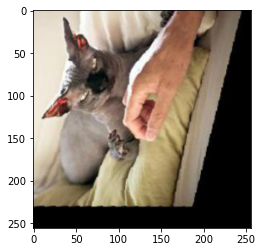

In [4]:
train_b1_img, train_b1_label = next(iter(train_loader))
print('shape of training batch (images): {}'.format(train_b1_img.shape))
print('shape of training batch (labels): {}'.format(train_b1_label.shape))
plt.imshow(train_b1_img[np.random.randint(64)].permute(1,2,0))     #plt.imshow needs the shape to be (x,y,3)
plt.show()

# Model with 6 conv layers

In [4]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.4),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.5),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model1 = PetCNN6()
loss_function = nn.NLLLoss()


print(model1)


    


PetCNN6(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.4, inplace=False)
    (1): Conv2d(64, 128,

In [5]:
learning_rate = 0.001
decay_rate = 0.0003
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 200

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        


Epoch:0
Iteration:50
Time taken for the last 50 iterations: 67.68998289108276
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 63.84929418563843
Epoch:0
Iteration:150
Time taken for the last 50 iterations: 63.07009935379028
Epoch:0
Iteration:200
Time taken for the last 50 iterations: 63.236133337020874
Epoch:0
Iteration:250
Time taken for the last 50 iterations: 62.108588218688965
Epoch:1
Iteration:300
Time taken for the last 50 iterations: 60.90768551826477
Current training loss:3.5391812324523926
Current training accuracy:0.0634765625
Current validation loss:3.5208911895751953
Current validation accuracy:0.053715307265520096
Epoch:1
Iteration:350
Time taken for the last 50 iterations: 52.73277521133423
Current training loss:3.5046746730804443
Current training accuracy:0.06396484375
Current validation loss:3.488842725753784
Current validation accuracy:0.0626678615808487
Epoch:1
Iteration:400
Time taken for the last 50 iterations: 49.94701862335205
Current training loss:3.5

Current training loss:3.4352285861968994
Current training accuracy:0.072265625
Current validation loss:3.3882782459259033
Current validation accuracy:0.06893464922904968
Epoch:7
Iteration:1900
Time taken for the last 50 iterations: 43.81462097167969
Current training loss:3.4154510498046875
Current training accuracy:0.0849609375
Current validation loss:3.3657405376434326
Current validation accuracy:0.0922112837433815
Epoch:7
Iteration:1950
Time taken for the last 50 iterations: 43.62039256095886
Current training loss:3.416550397872925
Current training accuracy:0.08544921875
Current validation loss:3.3470239639282227
Current validation accuracy:0.09758280962705612
Epoch:7
Iteration:2000
Time taken for the last 50 iterations: 32.583515644073486
Current training loss:3.41107177734375
Current training accuracy:0.08447265625
Current validation loss:3.360083818435669
Current validation accuracy:0.09400179237127304
Epoch:7
Iteration:2050
Time taken for the last 50 iterations: 32.63817358016968

Current training loss:3.1698827743530273
Current training accuracy:0.14208984375
Current validation loss:3.0601859092712402
Current validation accuracy:0.1665174514055252
Epoch:13
Iteration:3550
Time taken for the last 50 iterations: 33.31768488883972
Current training loss:3.156158924102783
Current training accuracy:0.15234375
Current validation loss:3.0473268032073975
Current validation accuracy:0.16293643414974213
Epoch:13
Iteration:3600
Time taken for the last 50 iterations: 33.2818169593811
Current training loss:3.225269079208374
Current training accuracy:0.11962890625
Current validation loss:3.088047742843628
Current validation accuracy:0.15129812061786652
Epoch:13
Iteration:3650
Time taken for the last 50 iterations: 33.59899950027466
Current training loss:3.1857810020446777
Current training accuracy:0.14208984375
Current validation loss:3.0734362602233887
Current validation accuracy:0.17636527121067047
Epoch:14
Iteration:3700
Time taken for the last 50 iterations: 31.27369713783

Epoch:19
Iteration:5150
Time taken for the last 50 iterations: 31.386457681655884
Current training loss:3.0250766277313232
Current training accuracy:0.18994140625
Current validation loss:2.918002128601074
Current validation accuracy:0.1996418982744217
Epoch:19
Iteration:5200
Time taken for the last 50 iterations: 31.524988651275635
Current training loss:2.98736572265625
Current training accuracy:0.19287109375
Current validation loss:2.8441338539123535
Current validation accuracy:0.21844226121902466
Epoch:20
Iteration:5250
Time taken for the last 50 iterations: 31.16060471534729
Current training loss:3.001854419708252
Current training accuracy:0.18359375
Current validation loss:2.9092471599578857
Current validation accuracy:0.18621307611465454
Epoch:20
Iteration:5300
Time taken for the last 50 iterations: 31.64366364479065
Current training loss:2.9860005378723145
Current training accuracy:0.18408203125
Current validation loss:2.8763256072998047
Current validation accuracy:0.198746636509

Current validation loss:2.7007997035980225
Current validation accuracy:0.2685765326023102
Epoch:26
Iteration:6800
Time taken for the last 50 iterations: 31.556988954544067
Current training loss:2.964421033859253
Current training accuracy:0.197265625
Current validation loss:2.833160400390625
Current validation accuracy:0.2229185253381729
Epoch:26
Iteration:6850
Time taken for the last 50 iterations: 31.86544632911682
Current training loss:2.9206290245056152
Current training accuracy:0.20751953125
Current validation loss:2.755032539367676
Current validation accuracy:0.2506714463233948
Epoch:26
Iteration:6900
Time taken for the last 50 iterations: 32.01896929740906
Current training loss:2.8560421466827393
Current training accuracy:0.22021484375
Current validation loss:2.7421743869781494
Current validation accuracy:0.24888093769550323
Epoch:26
Iteration:6950
Time taken for the last 50 iterations: 32.686870098114014
Current training loss:2.876336097717285
Current training accuracy:0.2236328

Current training loss:2.6942977905273438
Current training accuracy:0.25732421875
Current validation loss:2.5879642963409424
Current validation accuracy:0.2918531894683838
Epoch:32
Iteration:8450
Time taken for the last 50 iterations: 31.49124789237976
Current training loss:2.706693410873413
Current training accuracy:0.2705078125
Current validation loss:2.5967907905578613
Current validation accuracy:0.28111010789871216
Epoch:32
Iteration:8500
Time taken for the last 50 iterations: 31.58500647544861
Current training loss:2.6884543895721436
Current training accuracy:0.2666015625
Current validation loss:2.558870553970337
Current validation accuracy:0.3070725202560425
Epoch:32
Iteration:8550
Time taken for the last 50 iterations: 31.459017753601074
Current training loss:2.6969971656799316
Current training accuracy:0.26611328125
Current validation loss:2.562756061553955
Current validation accuracy:0.3061772584915161
Epoch:32
Iteration:8600
Time taken for the last 50 iterations: 32.0718028545

Epoch:38
Iteration:10050
Time taken for the last 50 iterations: 32.61924767494202
Current training loss:2.504406452178955
Current training accuracy:0.31591796875
Current validation loss:2.40177059173584
Current validation accuracy:0.3303491473197937
Epoch:38
Iteration:10100
Time taken for the last 50 iterations: 31.328989505767822
Current training loss:2.5078747272491455
Current training accuracy:0.3154296875
Current validation loss:2.4319772720336914
Current validation accuracy:0.32318711280822754
Epoch:38
Iteration:10150
Time taken for the last 50 iterations: 31.495238304138184
Current training loss:2.4926602840423584
Current training accuracy:0.31201171875
Current validation loss:2.4851274490356445
Current validation accuracy:0.31154879927635193
Epoch:39
Iteration:10200
Time taken for the last 50 iterations: 30.89225697517395
Current training loss:2.5816612243652344
Current training accuracy:0.28857421875
Current validation loss:2.5144715309143066
Current validation accuracy:0.31692

Current validation loss:2.4236574172973633
Current validation accuracy:0.3393017053604126
Epoch:44
Iteration:11700
Time taken for the last 50 iterations: 31.37124729156494
Current training loss:2.4701621532440186
Current training accuracy:0.33154296875
Current validation loss:2.399768114089966
Current validation accuracy:0.3393017053604126
Epoch:45
Iteration:11750
Time taken for the last 50 iterations: 30.43660831451416
Current training loss:2.486515760421753
Current training accuracy:0.31787109375
Current validation loss:2.4517438411712646
Current validation accuracy:0.3213965892791748
Epoch:45
Iteration:11800
Time taken for the last 50 iterations: 31.063349962234497
Current training loss:2.4101693630218506
Current training accuracy:0.3505859375
Current validation loss:2.393418312072754
Current validation accuracy:0.3357206881046295
Epoch:45
Iteration:11850
Time taken for the last 50 iterations: 30.90059232711792
Current training loss:2.4451522827148438
Current training accuracy:0.336

Current training loss:2.378246545791626
Current training accuracy:0.353515625
Current validation loss:2.3045945167541504
Current validation accuracy:0.3634735941886902
Epoch:51
Iteration:13350
Time taken for the last 50 iterations: 30.51622176170349
Current training loss:2.789283275604248
Current training accuracy:0.2451171875
Current validation loss:2.723457098007202
Current validation accuracy:0.261414498090744
Epoch:51
Iteration:13400
Time taken for the last 50 iterations: 30.945733308792114
Current training loss:2.6859257221221924
Current training accuracy:0.27880859375
Current validation loss:2.594331979751587
Current validation accuracy:0.29632946848869324
Epoch:51
Iteration:13450
Time taken for the last 50 iterations: 30.84909462928772
Current training loss:2.6350197792053223
Current training accuracy:0.28662109375
Current validation loss:2.5303256511688232
Current validation accuracy:0.2981199622154236
Epoch:51
Iteration:13500
Time taken for the last 50 iterations: 30.923245906

Epoch:57
Iteration:14950
Time taken for the last 50 iterations: 32.27597618103027
Current training loss:2.290311813354492
Current training accuracy:0.38427734375
Current validation loss:2.290713310241699
Current validation accuracy:0.36436885595321655
Epoch:57
Iteration:15000
Time taken for the last 50 iterations: 31.534091472625732
Current training loss:2.358231782913208
Current training accuracy:0.36767578125
Current validation loss:2.2873640060424805
Current validation accuracy:0.3625783324241638
Epoch:57
Iteration:15050
Time taken for the last 50 iterations: 31.11404514312744
Current training loss:2.326504707336426
Current training accuracy:0.38232421875
Current validation loss:2.271224021911621
Current validation accuracy:0.38227394223213196
Epoch:57
Iteration:15100
Time taken for the last 50 iterations: 31.783272743225098
Current training loss:2.323317050933838
Current training accuracy:0.3681640625
Current validation loss:2.2806239128112793
Current validation accuracy:0.36257833

Current validation loss:2.2752833366394043
Current validation accuracy:0.38854074478149414
Epoch:63
Iteration:16600
Time taken for the last 50 iterations: 32.957515239715576
Current training loss:2.298576593399048
Current training accuracy:0.37890625
Current validation loss:2.251784324645996
Current validation accuracy:0.3876454830169678
Epoch:63
Iteration:16650
Time taken for the last 50 iterations: 33.17865228652954
Current training loss:2.3610074520111084
Current training accuracy:0.3525390625
Current validation loss:2.2918169498443604
Current validation accuracy:0.36436885595321655
Epoch:63
Iteration:16700
Time taken for the last 50 iterations: 33.212026596069336
Current training loss:2.266632080078125
Current training accuracy:0.38671875
Current validation loss:2.259207010269165
Current validation accuracy:0.38585495948791504
Epoch:64
Iteration:16750
Time taken for the last 50 iterations: 32.65717625617981
Current training loss:2.293567419052124
Current training accuracy:0.3686523

Current training loss:2.1721391677856445
Current training accuracy:0.41259765625
Current validation loss:2.1682820320129395
Current validation accuracy:0.39122650027275085
Epoch:69
Iteration:18250
Time taken for the last 50 iterations: 34.6946656703949
Current training loss:2.174940347671509
Current training accuracy:0.40869140625
Current validation loss:2.1619770526885986
Current validation accuracy:0.38854074478149414
Epoch:70
Iteration:18300
Time taken for the last 50 iterations: 33.871230602264404
Current training loss:2.130718469619751
Current training accuracy:0.4443359375
Current validation loss:2.1421549320220947
Current validation accuracy:0.39122650027275085
Epoch:70
Iteration:18350
Time taken for the last 50 iterations: 34.4890992641449
Current training loss:2.2191998958587646
Current training accuracy:0.36767578125
Current validation loss:2.177309036254883
Current validation accuracy:0.38854074478149414
Epoch:70
Iteration:18400
Time taken for the last 50 iterations: 33.8688

Epoch:76
Iteration:19850
Time taken for the last 50 iterations: 34.0124785900116
Current training loss:2.2198593616485596
Current training accuracy:0.412109375
Current validation loss:2.1660356521606445
Current validation accuracy:0.3894359767436981
Epoch:76
Iteration:19900
Time taken for the last 50 iterations: 34.82800602912903
Current training loss:2.1968259811401367
Current training accuracy:0.40771484375
Current validation loss:2.1672253608703613
Current validation accuracy:0.39391225576400757
Epoch:76
Iteration:19950
Time taken for the last 50 iterations: 34.40124535560608
Current training loss:2.1867010593414307
Current training accuracy:0.40869140625
Current validation loss:2.162569999694824
Current validation accuracy:0.4019695520401001
Epoch:76
Iteration:20000
Time taken for the last 50 iterations: 34.75917673110962
Current training loss:2.1388866901397705
Current training accuracy:0.41748046875
Current validation loss:2.134547472000122
Current validation accuracy:0.387645483

Current validation loss:2.1474461555480957
Current validation accuracy:0.3804834485054016
Epoch:82
Iteration:21500
Time taken for the last 50 iterations: 31.50215721130371
Current training loss:2.1307663917541504
Current training accuracy:0.41357421875
Current validation loss:2.1450469493865967
Current validation accuracy:0.38854074478149414
Epoch:82
Iteration:21550
Time taken for the last 50 iterations: 32.91662001609802
Current training loss:2.075270652770996
Current training accuracy:0.4453125
Current validation loss:2.092186212539673
Current validation accuracy:0.40913161635398865
Epoch:82
Iteration:21600
Time taken for the last 50 iterations: 31.379220962524414
Current training loss:2.141047716140747
Current training accuracy:0.43017578125
Current validation loss:2.135014772415161
Current validation accuracy:0.40376007556915283
Epoch:82
Iteration:21650
Time taken for the last 50 iterations: 32.060672998428345
Current training loss:2.115581512451172
Current training accuracy:0.4291

Current training loss:2.1048805713653564
Current training accuracy:0.4423828125
Current validation loss:2.124018669128418
Current validation accuracy:0.41181737184524536
Epoch:88
Iteration:23150
Time taken for the last 50 iterations: 35.510268211364746
Current training loss:2.100973129272461
Current training accuracy:0.42919921875
Current validation loss:2.0987720489501953
Current validation accuracy:0.4198746681213379
Epoch:88
Iteration:23200
Time taken for the last 50 iterations: 35.585992097854614
Current training loss:2.1031785011291504
Current training accuracy:0.41650390625
Current validation loss:2.1417627334594727
Current validation accuracy:0.4082363545894623
Epoch:89
Iteration:23250
Time taken for the last 50 iterations: 34.89323043823242
Current training loss:2.065934896469116
Current training accuracy:0.4501953125
Current validation loss:2.0870277881622314
Current validation accuracy:0.4145031273365021
Epoch:89
Iteration:23300
Time taken for the last 50 iterations: 35.59786

Epoch:94
Iteration:24750
Time taken for the last 50 iterations: 30.438931465148926
Current training loss:1.9848787784576416
Current training accuracy:0.4619140625
Current validation loss:2.034877300262451
Current validation accuracy:0.4162936508655548
Epoch:95
Iteration:24800
Time taken for the last 50 iterations: 29.632734775543213
Current training loss:2.102956771850586
Current training accuracy:0.44677734375
Current validation loss:2.1769611835479736
Current validation accuracy:0.3921217620372772
Epoch:95
Iteration:24850
Time taken for the last 50 iterations: 30.284181594848633
Current training loss:2.080740451812744
Current training accuracy:0.43701171875
Current validation loss:2.134316921234131
Current validation accuracy:0.3930170238018036
Epoch:95
Iteration:24900
Time taken for the last 50 iterations: 30.20274066925049
Current training loss:2.0416533946990967
Current training accuracy:0.46630859375
Current validation loss:2.067704200744629
Current validation accuracy:0.42166516

Current validation loss:2.138596296310425
Current validation accuracy:0.4055505692958832
Epoch:101
Iteration:26400
Time taken for the last 50 iterations: 29.708332061767578
Current training loss:2.2593038082122803
Current training accuracy:0.39208984375
Current validation loss:2.253493070602417
Current validation accuracy:0.3634735941886902
Epoch:101
Iteration:26450
Time taken for the last 50 iterations: 30.222856998443604
Current training loss:2.216825008392334
Current training accuracy:0.40283203125
Current validation loss:2.2203586101531982
Current validation accuracy:0.3867502212524414
Epoch:101
Iteration:26500
Time taken for the last 50 iterations: 29.71789264678955
Current training loss:2.21201491355896
Current training accuracy:0.3994140625
Current validation loss:2.2274086475372314
Current validation accuracy:0.3751119077205658
Epoch:101
Iteration:26550
Time taken for the last 50 iterations: 30.0989933013916
Current training loss:2.1325747966766357
Current training accuracy:0.4

Current training loss:1.9245233535766602
Current training accuracy:0.47119140625
Current validation loss:2.037753105163574
Current validation accuracy:0.4252462089061737
Epoch:107
Iteration:28050
Time taken for the last 50 iterations: 30.65151572227478
Current training loss:1.908428430557251
Current training accuracy:0.50341796875
Current validation loss:2.026205539703369
Current validation accuracy:0.43330350518226624
Epoch:107
Iteration:28100
Time taken for the last 50 iterations: 30.866660356521606
Current training loss:1.9561128616333008
Current training accuracy:0.46630859375
Current validation loss:2.0083022117614746
Current validation accuracy:0.4341987371444702
Epoch:107
Iteration:28150
Time taken for the last 50 iterations: 31.285069704055786
Current training loss:1.8870625495910645
Current training accuracy:0.4853515625
Current validation loss:2.0011188983917236
Current validation accuracy:0.42972245812416077
Epoch:108
Iteration:28200
Time taken for the last 50 iterations: 30

Epoch:113
Iteration:29650
Time taken for the last 50 iterations: 33.61891484260559
Current training loss:1.8985106945037842
Current training accuracy:0.5029296875
Current validation loss:2.009605884552002
Current validation accuracy:0.4404655396938324
Epoch:113
Iteration:29700
Time taken for the last 50 iterations: 33.5005784034729
Current training loss:1.9112719297409058
Current training accuracy:0.49853515625
Current validation loss:2.0088553428649902
Current validation accuracy:0.4467323124408722
Epoch:113
Iteration:29750
Time taken for the last 50 iterations: 33.463019132614136
Current training loss:1.8925061225891113
Current training accuracy:0.49658203125
Current validation loss:1.9869897365570068
Current validation accuracy:0.42076992988586426
Epoch:114
Iteration:29800
Time taken for the last 50 iterations: 32.818864822387695
Current training loss:2.001037359237671
Current training accuracy:0.470703125
Current validation loss:2.062338352203369
Current validation accuracy:0.41271

Current validation loss:1.9720221757888794
Current validation accuracy:0.4494180977344513
Epoch:119
Iteration:31300
Time taken for the last 50 iterations: 36.193029165267944
Current training loss:1.8412253856658936
Current training accuracy:0.5361328125
Current validation loss:1.9533791542053223
Current validation accuracy:0.4458370506763458
Epoch:120
Iteration:31350
Time taken for the last 50 iterations: 35.907050371170044
Current training loss:1.8288050889968872
Current training accuracy:0.53271484375
Current validation loss:1.9712008237838745
Current validation accuracy:0.43330350518226624
Epoch:120
Iteration:31400
Time taken for the last 50 iterations: 36.50766396522522
Current training loss:1.8066043853759766
Current training accuracy:0.54345703125
Current validation loss:1.9583444595336914
Current validation accuracy:0.4404655396938324
Epoch:120
Iteration:31450
Time taken for the last 50 iterations: 36.4303674697876
Current training loss:1.8458929061889648
Current training accura

Current training loss:2.2158308029174805
Current training accuracy:0.4189453125
Current validation loss:2.2424612045288086
Current validation accuracy:0.38495972752571106
Epoch:126
Iteration:32950
Time taken for the last 50 iterations: 39.672873973846436
Current training loss:1.9575815200805664
Current training accuracy:0.482421875
Current validation loss:2.0817205905914307
Current validation accuracy:0.41271263360977173
Epoch:126
Iteration:33000
Time taken for the last 50 iterations: 39.79112648963928
Current training loss:1.9434716701507568
Current training accuracy:0.5009765625
Current validation loss:2.049365282058716
Current validation accuracy:0.42345568537712097
Epoch:126
Iteration:33050
Time taken for the last 50 iterations: 39.93742370605469
Current training loss:1.9227951765060425
Current training accuracy:0.5029296875
Current validation loss:2.019296646118164
Current validation accuracy:0.43330350518226624
Epoch:126
Iteration:33100
Time taken for the last 50 iterations: 40.0

Epoch:132
Iteration:34550
Time taken for the last 50 iterations: 39.09879112243652
Current training loss:1.897338628768921
Current training accuracy:0.52734375
Current validation loss:2.046332836151123
Current validation accuracy:0.42345568537712097
Epoch:132
Iteration:34600
Time taken for the last 50 iterations: 39.456790924072266
Current training loss:1.966902494430542
Current training accuracy:0.4794921875
Current validation loss:2.069596290588379
Current validation accuracy:0.4082363545894623
Epoch:132
Iteration:34650
Time taken for the last 50 iterations: 39.299712896347046
Current training loss:1.9213528633117676
Current training accuracy:0.501953125
Current validation loss:2.047312021255493
Current validation accuracy:0.42435094714164734
Epoch:132
Iteration:34700
Time taken for the last 50 iterations: 39.174721240997314
Current training loss:1.8859676122665405
Current training accuracy:0.50830078125
Current validation loss:2.015333414077759
Current validation accuracy:0.42793196

Current validation loss:1.9799717664718628
Current validation accuracy:0.42076992988586426
Epoch:138
Iteration:36200
Time taken for the last 50 iterations: 39.124706745147705
Current training loss:1.7843987941741943
Current training accuracy:0.52783203125
Current validation loss:1.971815586090088
Current validation accuracy:0.42166516184806824
Epoch:138
Iteration:36250
Time taken for the last 50 iterations: 39.02725100517273
Current training loss:1.8265469074249268
Current training accuracy:0.53076171875
Current validation loss:1.964216947555542
Current validation accuracy:0.43061771988868713
Epoch:139
Iteration:36300
Time taken for the last 50 iterations: 37.95982003211975
Current training loss:1.783560037612915
Current training accuracy:0.53955078125
Current validation loss:1.9449750185012817
Current validation accuracy:0.4404655396938324
Epoch:139
Iteration:36350
Time taken for the last 50 iterations: 38.93965291976929
Current training loss:1.7894529104232788
Current training accura

Epoch:144
Iteration:37800
Time taken for the last 50 iterations: 39.55186605453491
Current training loss:1.7077622413635254
Current training accuracy:0.5595703125
Current validation loss:1.8966922760009766
Current validation accuracy:0.452103853225708
Epoch:145
Iteration:37850
Time taken for the last 50 iterations: 38.8549382686615
Current training loss:1.772372841835022
Current training accuracy:0.54052734375
Current validation loss:1.93583345413208
Current validation accuracy:0.4368845224380493
Epoch:145
Iteration:37900
Time taken for the last 50 iterations: 39.63025403022766
Current training loss:1.74337899684906
Current training accuracy:0.55712890625
Current validation loss:1.9127259254455566
Current validation accuracy:0.44136080145835876
Epoch:145
Iteration:37950
Time taken for the last 50 iterations: 39.40487456321716
Current training loss:1.740648627281189
Current training accuracy:0.56640625
Current validation loss:1.9162304401397705
Current validation accuracy:0.448522835969

Current validation loss:1.916990876197815
Current validation accuracy:0.4404655396938324
Epoch:151
Iteration:39450
Time taken for the last 50 iterations: 41.6682186126709
Current training loss:1.8975908756256104
Current training accuracy:0.498046875
Current validation loss:2.087864637374878
Current validation accuracy:0.42076992988586426
Epoch:151
Iteration:39500
Time taken for the last 50 iterations: 42.77443528175354
Current training loss:1.893894076347351
Current training accuracy:0.51171875
Current validation loss:2.0417706966400146
Current validation accuracy:0.4162936508655548
Epoch:151
Iteration:39550
Time taken for the last 50 iterations: 42.88475155830383
Current training loss:1.858907699584961
Current training accuracy:0.53662109375
Current validation loss:1.9831326007843018
Current validation accuracy:0.4350939989089966
Epoch:151
Iteration:39600
Time taken for the last 50 iterations: 56.36404371261597
Current training loss:1.7751057147979736
Current training accuracy:0.55371

Current training loss:1.7933032512664795
Current training accuracy:0.5341796875
Current validation loss:1.9413083791732788
Current validation accuracy:0.4377797544002533
Epoch:157
Iteration:41100
Time taken for the last 50 iterations: 55.49905252456665
Current training loss:1.7644916772842407
Current training accuracy:0.55126953125
Current validation loss:1.9566329717636108
Current validation accuracy:0.4377797544002533
Epoch:157
Iteration:41150
Time taken for the last 50 iterations: 58.21506953239441
Current training loss:1.7449710369110107
Current training accuracy:0.544921875
Current validation loss:1.9218968152999878
Current validation accuracy:0.4431512951850891
Epoch:157
Iteration:41200
Time taken for the last 50 iterations: 55.154829025268555
Current training loss:1.703229546546936
Current training accuracy:0.57666015625
Current validation loss:1.9287647008895874
Current validation accuracy:0.4494180977344513
Epoch:158
Iteration:41250
Time taken for the last 50 iterations: 55.24

Epoch:163
Iteration:42700
Time taken for the last 50 iterations: 64.53282475471497
Current training loss:1.733054757118225
Current training accuracy:0.56689453125
Current validation loss:1.9010637998580933
Current validation accuracy:0.46553269028663635
Epoch:163
Iteration:42750
Time taken for the last 50 iterations: 69.83417248725891
Current training loss:1.7380845546722412
Current training accuracy:0.5439453125
Current validation loss:1.9144948720932007
Current validation accuracy:0.4494180977344513
Epoch:163
Iteration:42800
Time taken for the last 50 iterations: 80.19338202476501
Current training loss:1.6686480045318604
Current training accuracy:0.57568359375
Current validation loss:1.9020106792449951
Current validation accuracy:0.46821844577789307
Epoch:164
Iteration:42850
Time taken for the last 50 iterations: 57.432443618774414
Current training loss:1.6803736686706543
Current training accuracy:0.57763671875
Current validation loss:1.901391625404358
Current validation accuracy:0.4

Current validation loss:1.8778835535049438
Current validation accuracy:0.45926588773727417
Epoch:169
Iteration:44350
Time taken for the last 50 iterations: 47.37173080444336
Current training loss:1.6450228691101074
Current training accuracy:0.56982421875
Current validation loss:1.879307508468628
Current validation accuracy:0.46642792224884033
Epoch:170
Iteration:44400
Time taken for the last 50 iterations: 46.34357953071594
Current training loss:1.9281458854675293
Current training accuracy:0.47216796875
Current validation loss:2.097712278366089
Current validation accuracy:0.4136078655719757
Epoch:170
Iteration:44450
Time taken for the last 50 iterations: 47.59281039237976
Current training loss:1.8292285203933716
Current training accuracy:0.521484375
Current validation loss:2.0280990600585938
Current validation accuracy:0.4288272261619568
Epoch:170
Iteration:44500
Time taken for the last 50 iterations: 47.51363277435303
Current training loss:1.7866767644882202
Current training accuracy:

Current training loss:1.5764102935791016
Current training accuracy:0.6044921875
Current validation loss:1.8875685930252075
Current validation accuracy:0.4762757420539856
Epoch:176
Iteration:46000
Time taken for the last 50 iterations: 51.0533766746521
Current training loss:1.6125353574752808
Current training accuracy:0.59033203125
Current validation loss:1.8644235134124756
Current validation accuracy:0.4905998110771179
Epoch:176
Iteration:46050
Time taken for the last 50 iterations: 50.66321659088135
Current training loss:1.637683391571045
Current training accuracy:0.5888671875
Current validation loss:1.8631850481033325
Current validation accuracy:0.4619516432285309
Epoch:176
Iteration:46100
Time taken for the last 50 iterations: 50.96292519569397
Current training loss:1.645532488822937
Current training accuracy:0.5966796875
Current validation loss:1.8877967596054077
Current validation accuracy:0.46642792224884033
Epoch:176
Iteration:46150
Time taken for the last 50 iterations: 51.0003

Epoch:182
Iteration:47600
Time taken for the last 50 iterations: 51.768994092941284
Current training loss:1.6423401832580566
Current training accuracy:0.58203125
Current validation loss:1.885451316833496
Current validation accuracy:0.4726947247982025
Epoch:182
Iteration:47650
Time taken for the last 50 iterations: 51.99376726150513
Current training loss:1.6013370752334595
Current training accuracy:0.60888671875
Current validation loss:1.8808836936950684
Current validation accuracy:0.4637421667575836
Epoch:182
Iteration:47700
Time taken for the last 50 iterations: 52.0322949886322
Current training loss:1.6170870065689087
Current training accuracy:0.59130859375
Current validation loss:1.8795822858810425
Current validation accuracy:0.4735899865627289
Epoch:182
Iteration:47750
Time taken for the last 50 iterations: 51.702022552490234
Current training loss:1.6599156856536865
Current training accuracy:0.5830078125
Current validation loss:1.8957222700119019
Current validation accuracy:0.46284

Current validation loss:1.903786063194275
Current validation accuracy:0.45926588773727417
Epoch:188
Iteration:49250
Time taken for the last 50 iterations: 51.42427897453308
Current training loss:1.6421674489974976
Current training accuracy:0.583984375
Current validation loss:1.8667608499526978
Current validation accuracy:0.4726947247982025
Epoch:188
Iteration:49300
Time taken for the last 50 iterations: 51.48825168609619
Current training loss:1.6174198389053345
Current training accuracy:0.6083984375
Current validation loss:1.8750931024551392
Current validation accuracy:0.47448521852493286
Epoch:189
Iteration:49350
Time taken for the last 50 iterations: 50.4007785320282
Current training loss:1.7971065044403076
Current training accuracy:0.53759765625
Current validation loss:1.9755487442016602
Current validation accuracy:0.42703670263290405
Epoch:189
Iteration:49400
Time taken for the last 50 iterations: 51.32141923904419
Current training loss:1.759395956993103
Current training accuracy:0

Current training loss:1.5833626985549927
Current training accuracy:0.6083984375
Current validation loss:1.8628123998641968
Current validation accuracy:0.47448521852493286
Epoch:195
Iteration:50900
Time taken for the last 50 iterations: 47.88408660888672
Current training loss:2.0412957668304443
Current training accuracy:0.5048828125
Current validation loss:2.217259407043457
Current validation accuracy:0.4100268483161926
Epoch:195
Iteration:50950
Time taken for the last 50 iterations: 49.4439218044281
Current training loss:1.7174257040023804
Current training accuracy:0.54052734375
Current validation loss:1.9753785133361816
Current validation accuracy:0.4431512951850891
Epoch:195
Iteration:51000
Time taken for the last 50 iterations: 49.23619818687439
Current training loss:1.7078561782836914
Current training accuracy:0.57177734375
Current validation loss:1.944931983947754
Current validation accuracy:0.4494180977344513
Epoch:195
Iteration:51050
Time taken for the last 50 iterations: 49.255

In [6]:
num_epochs=150

start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                


Epoch:0
Iteration:52250
Time taken for the last 50 iterations: 48.649895906448364
Epoch:0
Iteration:52300
Time taken for the last 50 iterations: 49.45180940628052
Epoch:0
Iteration:52350
Time taken for the last 50 iterations: 49.86306858062744
Epoch:0
Iteration:52400
Time taken for the last 50 iterations: 49.94440817832947
Epoch:0
Iteration:52450
Time taken for the last 50 iterations: 50.01185631752014
Epoch:1
Iteration:52500
Time taken for the last 50 iterations: 48.691011905670166
Current training loss:1.7224167585372925
Current training accuracy:0.55322265625
Current validation loss:1.9509974718093872
Current validation accuracy:0.4377797544002533
Epoch:1
Iteration:52550
Time taken for the last 50 iterations: 47.67137026786804
Current training loss:1.6981415748596191
Current training accuracy:0.5859375
Current validation loss:1.9254885911941528
Current validation accuracy:0.4503133296966553
Epoch:1
Iteration:52600
Time taken for the last 50 iterations: 48.6291446685791
Current train

Current training loss:1.616464376449585
Current training accuracy:0.5810546875
Current validation loss:1.9010404348373413
Current validation accuracy:0.4494180977344513
Epoch:7
Iteration:54100
Time taken for the last 50 iterations: 48.05267786979675
Current training loss:1.5739368200302124
Current training accuracy:0.61328125
Current validation loss:1.8870279788970947
Current validation accuracy:0.4619516432285309
Epoch:7
Iteration:54150
Time taken for the last 50 iterations: 48.500964641571045
Current training loss:1.5997307300567627
Current training accuracy:0.6181640625
Current validation loss:1.8626662492752075
Current validation accuracy:0.4798567593097687
Epoch:7
Iteration:54200
Time taken for the last 50 iterations: 48.989461183547974
Current training loss:1.5469589233398438
Current training accuracy:0.60546875
Current validation loss:1.868516206741333
Current validation accuracy:0.46553269028663635
Epoch:7
Iteration:54250
Time taken for the last 50 iterations: 48.91119360923767

Epoch:13
Iteration:55700
Time taken for the last 50 iterations: 48.07776999473572
Current training loss:1.677191972732544
Current training accuracy:0.58349609375
Current validation loss:1.9241949319839478
Current validation accuracy:0.4529991149902344
Epoch:13
Iteration:55750
Time taken for the last 50 iterations: 48.256266593933105
Current training loss:1.6314281225204468
Current training accuracy:0.60498046875
Current validation loss:1.8962987661361694
Current validation accuracy:0.4619516432285309
Epoch:13
Iteration:55800
Time taken for the last 50 iterations: 48.499706506729126
Current training loss:1.5896869897842407
Current training accuracy:0.62548828125
Current validation loss:1.9071065187454224
Current validation accuracy:0.4574753940105438
Epoch:13
Iteration:55850
Time taken for the last 50 iterations: 48.3858060836792
Current training loss:1.5894654989242554
Current training accuracy:0.5986328125
Current validation loss:1.8910149335861206
Current validation accuracy:0.452999

Current validation loss:1.8619871139526367
Current validation accuracy:0.4709042012691498
Epoch:19
Iteration:57350
Time taken for the last 50 iterations: 50.43932914733887
Current training loss:1.6078087091445923
Current training accuracy:0.6240234375
Current validation loss:1.8649952411651611
Current validation accuracy:0.4762757420539856
Epoch:19
Iteration:57400
Time taken for the last 50 iterations: 50.43639659881592
Current training loss:1.5800074338912964
Current training accuracy:0.61669921875
Current validation loss:1.8625125885009766
Current validation accuracy:0.4700089395046234
Epoch:20
Iteration:57450
Time taken for the last 50 iterations: 49.2372350692749
Current training loss:1.7277567386627197
Current training accuracy:0.55859375
Current validation loss:1.9189248085021973
Current validation accuracy:0.4503133296966553
Epoch:20
Iteration:57500
Time taken for the last 50 iterations: 50.518393993377686
Current training loss:1.702385663986206
Current training accuracy:0.55419

Current training loss:1.7125226259231567
Current training accuracy:0.57666015625
Current validation loss:1.9534447193145752
Current validation accuracy:0.44494181871414185
Epoch:26
Iteration:59000
Time taken for the last 50 iterations: 48.769609689712524
Current training loss:1.7256253957748413
Current training accuracy:0.57177734375
Current validation loss:1.9432944059371948
Current validation accuracy:0.4440465569496155
Epoch:26
Iteration:59050
Time taken for the last 50 iterations: 49.72693657875061
Current training loss:1.6640876531600952
Current training accuracy:0.599609375
Current validation loss:1.9095512628555298
Current validation accuracy:0.45926588773727417
Epoch:26
Iteration:59100
Time taken for the last 50 iterations: 49.42187452316284
Current training loss:1.7187702655792236
Current training accuracy:0.5771484375
Current validation loss:1.922515869140625
Current validation accuracy:0.4494180977344513
Epoch:26
Iteration:59150
Time taken for the last 50 iterations: 49.7334

Epoch:32
Iteration:60600
Time taken for the last 50 iterations: 48.55898427963257
Current training loss:1.598487138748169
Current training accuracy:0.59619140625
Current validation loss:1.9001299142837524
Current validation accuracy:0.46016114950180054
Epoch:32
Iteration:60650
Time taken for the last 50 iterations: 49.72021555900574
Current training loss:1.615991473197937
Current training accuracy:0.59619140625
Current validation loss:1.8782191276550293
Current validation accuracy:0.46911370754241943
Epoch:32
Iteration:60700
Time taken for the last 50 iterations: 49.344571590423584
Current training loss:1.5817805528640747
Current training accuracy:0.61865234375
Current validation loss:1.8575975894927979
Current validation accuracy:0.46821844577789307
Epoch:32
Iteration:60750
Time taken for the last 50 iterations: 49.458029985427856
Current training loss:1.6047098636627197
Current training accuracy:0.6005859375
Current validation loss:1.8472306728363037
Current validation accuracy:0.469

Current validation loss:1.9528721570968628
Current validation accuracy:0.4467323124408722
Epoch:38
Iteration:62250
Time taken for the last 50 iterations: 48.030768394470215
Current training loss:1.656153917312622
Current training accuracy:0.5771484375
Current validation loss:1.8867666721343994
Current validation accuracy:0.4673231840133667
Epoch:38
Iteration:62300
Time taken for the last 50 iterations: 48.23672866821289
Current training loss:1.6447994709014893
Current training accuracy:0.58349609375
Current validation loss:1.8942652940750122
Current validation accuracy:0.45658013224601746
Epoch:38
Iteration:62350
Time taken for the last 50 iterations: 48.61528944969177
Current training loss:1.6217137575149536
Current training accuracy:0.607421875
Current validation loss:1.8781148195266724
Current validation accuracy:0.46911370754241943
Epoch:39
Iteration:62400
Time taken for the last 50 iterations: 47.61411738395691
Current training loss:1.6161385774612427
Current training accuracy:0.6

Current training loss:1.4746171236038208
Current training accuracy:0.658203125
Current validation loss:1.8072926998138428
Current validation accuracy:0.4879140555858612
Epoch:44
Iteration:63900
Time taken for the last 50 iterations: 47.73490905761719
Current training loss:1.519187569618225
Current training accuracy:0.64697265625
Current validation loss:1.8472421169281006
Current validation accuracy:0.47448521852493286
Epoch:45
Iteration:63950
Time taken for the last 50 iterations: 46.896623611450195
Current training loss:1.5612123012542725
Current training accuracy:0.6279296875
Current validation loss:1.8383911848068237
Current validation accuracy:0.46821844577789307
Epoch:45
Iteration:64000
Time taken for the last 50 iterations: 47.6899197101593
Current training loss:1.4676809310913086
Current training accuracy:0.65185546875
Current validation loss:1.820879340171814
Current validation accuracy:0.4762757420539856
Epoch:45
Iteration:64050
Time taken for the last 50 iterations: 47.774046

Epoch:50
Iteration:65500
Time taken for the last 50 iterations: 50.17400407791138
Current training loss:1.5176950693130493
Current training accuracy:0.6142578125
Current validation loss:1.8046711683273315
Current validation accuracy:0.4879140555858612
Epoch:51
Iteration:65550
Time taken for the last 50 iterations: 49.81704330444336
Current training loss:1.5520408153533936
Current training accuracy:0.609375
Current validation loss:1.8739583492279053
Current validation accuracy:0.4619516432285309
Epoch:51
Iteration:65600
Time taken for the last 50 iterations: 50.69177770614624
Current training loss:1.6212002038955688
Current training accuracy:0.5986328125
Current validation loss:1.8808021545410156
Current validation accuracy:0.45926588773727417
Epoch:51
Iteration:65650
Time taken for the last 50 iterations: 50.74345636367798
Current training loss:1.5652838945388794
Current training accuracy:0.61474609375
Current validation loss:1.8422033786773682
Current validation accuracy:0.47090420126

Current validation loss:2.0600717067718506
Current validation accuracy:0.4467323124408722
Epoch:57
Iteration:67150
Time taken for the last 50 iterations: 52.313262701034546
Current training loss:1.6827847957611084
Current training accuracy:0.58984375
Current validation loss:1.9600361585617065
Current validation accuracy:0.452103853225708
Epoch:57
Iteration:67200
Time taken for the last 50 iterations: 52.353983879089355
Current training loss:1.6904469728469849
Current training accuracy:0.58935546875
Current validation loss:1.9332449436187744
Current validation accuracy:0.4610564112663269
Epoch:57
Iteration:67250
Time taken for the last 50 iterations: 52.38482332229614
Current training loss:1.6087102890014648
Current training accuracy:0.60595703125
Current validation loss:1.8970531225204468
Current validation accuracy:0.4574753940105438
Epoch:57
Iteration:67300
Time taken for the last 50 iterations: 52.467432260513306
Current training loss:1.5874478816986084
Current training accuracy:0.6

Current training loss:1.4667860269546509
Current training accuracy:0.6396484375
Current validation loss:1.8391894102096558
Current validation accuracy:0.4709042012691498
Epoch:63
Iteration:68800
Time taken for the last 50 iterations: 52.54807472229004
Current training loss:1.488404631614685
Current training accuracy:0.6474609375
Current validation loss:1.8456681966781616
Current validation accuracy:0.46553269028663635
Epoch:63
Iteration:68850
Time taken for the last 50 iterations: 52.44664454460144
Current training loss:1.4888216257095337
Current training accuracy:0.63134765625
Current validation loss:1.8625613451004028
Current validation accuracy:0.4673231840133667
Epoch:63
Iteration:68900
Time taken for the last 50 iterations: 52.84678316116333
Current training loss:1.4746884107589722
Current training accuracy:0.63525390625
Current validation loss:1.8530821800231934
Current validation accuracy:0.46642792224884033
Epoch:64
Iteration:68950
Time taken for the last 50 iterations: 51.7496

Epoch:69
Iteration:70400
Time taken for the last 50 iterations: 54.492841958999634
Current training loss:1.5004862546920776
Current training accuracy:0.642578125
Current validation loss:1.8431638479232788
Current validation accuracy:0.4583706259727478
Epoch:69
Iteration:70450
Time taken for the last 50 iterations: 54.622132778167725
Current training loss:1.4656741619110107
Current training accuracy:0.65673828125
Current validation loss:1.8508188724517822
Current validation accuracy:0.46642792224884033
Epoch:70
Iteration:70500
Time taken for the last 50 iterations: 53.60161995887756
Current training loss:1.6038719415664673
Current training accuracy:0.595703125
Current validation loss:1.971792459487915
Current validation accuracy:0.44225603342056274
Epoch:70
Iteration:70550
Time taken for the last 50 iterations: 54.830705404281616
Current training loss:1.580284595489502
Current training accuracy:0.62060546875
Current validation loss:1.906429409980774
Current validation accuracy:0.4583706

Current validation loss:1.796152949333191
Current validation accuracy:0.4798567593097687
Epoch:76
Iteration:72050
Time taken for the last 50 iterations: 56.61039352416992
Current training loss:1.5975981950759888
Current training accuracy:0.5947265625
Current validation loss:1.9317824840545654
Current validation accuracy:0.4467323124408722
Epoch:76
Iteration:72100
Time taken for the last 50 iterations: 57.841179609298706
Current training loss:1.5670992136001587
Current training accuracy:0.61181640625
Current validation loss:1.862744927406311
Current validation accuracy:0.47717100381851196
Epoch:76
Iteration:72150
Time taken for the last 50 iterations: 57.927014112472534
Current training loss:1.56705904006958
Current training accuracy:0.61669921875
Current validation loss:1.8563467264175415
Current validation accuracy:0.47448521852493286
Epoch:76
Iteration:72200
Time taken for the last 50 iterations: 57.937859535217285
Current training loss:1.532841444015503
Current training accuracy:0.6

Current training loss:1.6089097261428833
Current training accuracy:0.61962890625
Current validation loss:1.870653748512268
Current validation accuracy:0.4431512951850891
Epoch:82
Iteration:73700
Time taken for the last 50 iterations: 59.759483098983765
Current training loss:1.5598945617675781
Current training accuracy:0.62548828125
Current validation loss:1.8712151050567627
Current validation accuracy:0.47179946303367615
Epoch:82
Iteration:73750
Time taken for the last 50 iterations: 59.976096630096436
Current training loss:1.5224205255508423
Current training accuracy:0.63916015625
Current validation loss:1.8494234085083008
Current validation accuracy:0.4798567593097687
Epoch:82
Iteration:73800
Time taken for the last 50 iterations: 59.8623833656311
Current training loss:1.5338541269302368
Current training accuracy:0.63623046875
Current validation loss:1.8606594800949097
Current validation accuracy:0.47538048028945923
Epoch:82
Iteration:73850
Time taken for the last 50 iterations: 59.8

Epoch:88
Iteration:75300
Time taken for the last 50 iterations: 60.152454137802124
Current training loss:1.629517674446106
Current training accuracy:0.6083984375
Current validation loss:1.8806915283203125
Current validation accuracy:0.4789614975452423
Epoch:88
Iteration:75350
Time taken for the last 50 iterations: 59.94239544868469
Current training loss:1.5319297313690186
Current training accuracy:0.6240234375
Current validation loss:1.844904899597168
Current validation accuracy:0.4726947247982025
Epoch:88
Iteration:75400
Time taken for the last 50 iterations: 60.153417110443115
Current training loss:1.6018898487091064
Current training accuracy:0.6181640625
Current validation loss:1.8637406826019287
Current validation accuracy:0.46553269028663635
Epoch:89
Iteration:75450
Time taken for the last 50 iterations: 58.92746114730835
Current training loss:1.5574731826782227
Current training accuracy:0.63427734375
Current validation loss:1.8304595947265625
Current validation accuracy:0.4726947

Current validation loss:1.8471590280532837
Current validation accuracy:0.4700089395046234
Epoch:94
Iteration:76950
Time taken for the last 50 iterations: 59.482348918914795
Current training loss:1.5054354667663574
Current training accuracy:0.634765625
Current validation loss:1.8241325616836548
Current validation accuracy:0.4843330383300781
Epoch:95
Iteration:77000
Time taken for the last 50 iterations: 58.4969437122345
Current training loss:1.60120689868927
Current training accuracy:0.61328125
Current validation loss:1.8758095502853394
Current validation accuracy:0.47717100381851196
Epoch:95
Iteration:77050
Time taken for the last 50 iterations: 58.26644277572632
Current training loss:1.5835946798324585
Current training accuracy:0.62060546875
Current validation loss:1.862097978591919
Current validation accuracy:0.4556848704814911
Epoch:95
Iteration:77100
Time taken for the last 50 iterations: 58.13339304924011
Current training loss:1.528775691986084
Current training accuracy:0.62841796

Current training loss:1.4754316806793213
Current training accuracy:0.6533203125
Current validation loss:1.8001669645309448
Current validation accuracy:0.4852283000946045
Epoch:101
Iteration:78600
Time taken for the last 50 iterations: 56.184491872787476
Current training loss:1.523496389389038
Current training accuracy:0.64697265625
Current validation loss:1.8184293508529663
Current validation accuracy:0.48701879382133484
Epoch:101
Iteration:78650
Time taken for the last 50 iterations: 57.72950053215027
Current training loss:1.4930273294448853
Current training accuracy:0.6640625
Current validation loss:1.7941850423812866
Current validation accuracy:0.49239033460617065
Epoch:101
Iteration:78700
Time taken for the last 50 iterations: 57.17817449569702
Current training loss:1.5295803546905518
Current training accuracy:0.64111328125
Current validation loss:1.8190609216690063
Current validation accuracy:0.4843330383300781
Epoch:101
Iteration:78750
Time taken for the last 50 iterations: 56.62

Epoch:107
Iteration:80200
Time taken for the last 50 iterations: 52.177839517593384
Current training loss:1.5796629190444946
Current training accuracy:0.61328125
Current validation loss:1.8443541526794434
Current validation accuracy:0.4852283000946045
Epoch:107
Iteration:80250
Time taken for the last 50 iterations: 52.255526065826416
Current training loss:1.5511398315429688
Current training accuracy:0.6220703125
Current validation loss:1.8722302913665771
Current validation accuracy:0.4789614975452423
Epoch:107
Iteration:80300
Time taken for the last 50 iterations: 52.144299268722534
Current training loss:1.6217262744903564
Current training accuracy:0.6083984375
Current validation loss:1.842266321182251
Current validation accuracy:0.4789614975452423
Epoch:107
Iteration:80350
Time taken for the last 50 iterations: 51.92456674575806
Current training loss:1.5968830585479736
Current training accuracy:0.58349609375
Current validation loss:1.8683408498764038
Current validation accuracy:0.4744

Current training loss:1.6521108150482178
Current training accuracy:0.583984375
Current validation loss:1.945395827293396
Current validation accuracy:0.44225603342056274
Epoch:113
Iteration:81850
Time taken for the last 50 iterations: 52.333568811416626
Current training loss:1.6968002319335938
Current training accuracy:0.578125
Current validation loss:1.8905432224273682
Current validation accuracy:0.4726947247982025
Epoch:113
Iteration:81900
Time taken for the last 50 iterations: 52.7373480796814
Current training loss:1.5975525379180908
Current training accuracy:0.619140625
Current validation loss:1.8556097745895386
Current validation accuracy:0.4700089395046234
Epoch:113
Iteration:81950
Time taken for the last 50 iterations: 52.437644958496094
Current training loss:1.609395146369934
Current training accuracy:0.5966796875
Current validation loss:1.8731544017791748
Current validation accuracy:0.4494180977344513
Epoch:114
Iteration:82000
Time taken for the last 50 iterations: 51.242609500

Epoch:119
Iteration:83450
Time taken for the last 50 iterations: 54.099063873291016
Current training loss:1.4900590181350708
Current training accuracy:0.62890625
Current validation loss:1.8038769960403442
Current validation accuracy:0.4825425148010254
Epoch:119
Iteration:83500
Time taken for the last 50 iterations: 52.2284722328186
Current training loss:1.5322566032409668
Current training accuracy:0.6220703125
Current validation loss:1.7891520261764526
Current validation accuracy:0.47806623578071594
Epoch:120
Iteration:83550
Time taken for the last 50 iterations: 52.891626834869385
Current training loss:1.5036587715148926
Current training accuracy:0.650390625
Current validation loss:1.7973568439483643
Current validation accuracy:0.4852283000946045
Epoch:120
Iteration:83600
Time taken for the last 50 iterations: 52.57614541053772
Current training loss:1.4667332172393799
Current training accuracy:0.65234375
Current validation loss:1.8072409629821777
Current validation accuracy:0.47717100

Current validation loss:1.8142197132110596
Current validation accuracy:0.48075202107429504
Epoch:126
Iteration:85100
Time taken for the last 50 iterations: 53.17097043991089
Current training loss:1.454397439956665
Current training accuracy:0.65771484375
Current validation loss:1.8060919046401978
Current validation accuracy:0.48970457911491394
Epoch:126
Iteration:85150
Time taken for the last 50 iterations: 54.490962266922
Current training loss:1.4638890027999878
Current training accuracy:0.63330078125
Current validation loss:1.8072820901870728
Current validation accuracy:0.4825425148010254
Epoch:126
Iteration:85200
Time taken for the last 50 iterations: 54.53636026382446
Current training loss:1.4650264978408813
Current training accuracy:0.65673828125
Current validation loss:1.793595552444458
Current validation accuracy:0.4798567593097687
Epoch:126
Iteration:85250
Time taken for the last 50 iterations: 54.40545463562012
Current training loss:1.450666904449463
Current training accuracy:0

Epoch:132
Iteration:86700
Time taken for the last 50 iterations: 53.62667989730835
Current training loss:1.5044524669647217
Current training accuracy:0.63037109375
Current validation loss:1.8151048421859741
Current validation accuracy:0.4726947247982025
Epoch:132
Iteration:86750
Time taken for the last 50 iterations: 54.72951149940491
Current training loss:1.5413625240325928
Current training accuracy:0.6376953125
Current validation loss:1.8094329833984375
Current validation accuracy:0.47179946303367615
Epoch:132
Iteration:86800
Time taken for the last 50 iterations: 54.55898070335388
Current training loss:1.486037254333496
Current training accuracy:0.6474609375
Current validation loss:1.8151671886444092
Current validation accuracy:0.4798567593097687
Epoch:132
Iteration:86850
Time taken for the last 50 iterations: 54.523725748062134
Current training loss:1.5132173299789429
Current training accuracy:0.63525390625
Current validation loss:1.8108705282211304
Current validation accuracy:0.46

Current validation loss:1.8217096328735352
Current validation accuracy:0.48075202107429504
Epoch:138
Iteration:88350
Time taken for the last 50 iterations: 55.04970335960388
Current training loss:1.4825857877731323
Current training accuracy:0.63525390625
Current validation loss:1.8063137531280518
Current validation accuracy:0.46642792224884033
Epoch:138
Iteration:88400
Time taken for the last 50 iterations: 54.73923444747925
Current training loss:1.4841487407684326
Current training accuracy:0.6484375
Current validation loss:1.8119816780090332
Current validation accuracy:0.47806623578071594
Epoch:138
Iteration:88450
Time taken for the last 50 iterations: 54.260743141174316
Current training loss:1.398349642753601
Current training accuracy:0.67041015625
Current validation loss:1.7894047498703003
Current validation accuracy:0.48075202107429504
Epoch:139
Iteration:88500
Time taken for the last 50 iterations: 53.37391686439514
Current training loss:1.5933988094329834
Current training accurac

Current training loss:1.5215444564819336
Current training accuracy:0.63037109375
Current validation loss:1.835317850112915
Current validation accuracy:0.48075202107429504
Epoch:144
Iteration:90000
Time taken for the last 50 iterations: 58.51564025878906
Current training loss:1.460575819015503
Current training accuracy:0.66455078125
Current validation loss:1.8044356107711792
Current validation accuracy:0.4905998110771179
Epoch:145
Iteration:90050
Time taken for the last 50 iterations: 57.33220148086548
Current training loss:1.489312767982483
Current training accuracy:0.63720703125
Current validation loss:1.8332688808441162
Current validation accuracy:0.4798567593097687
Epoch:145
Iteration:90100
Time taken for the last 50 iterations: 58.452231884002686
Current training loss:1.4583802223205566
Current training accuracy:0.646484375
Current validation loss:1.8158575296401978
Current validation accuracy:0.4762757420539856
Epoch:145
Iteration:90150
Time taken for the last 50 iterations: 59.00

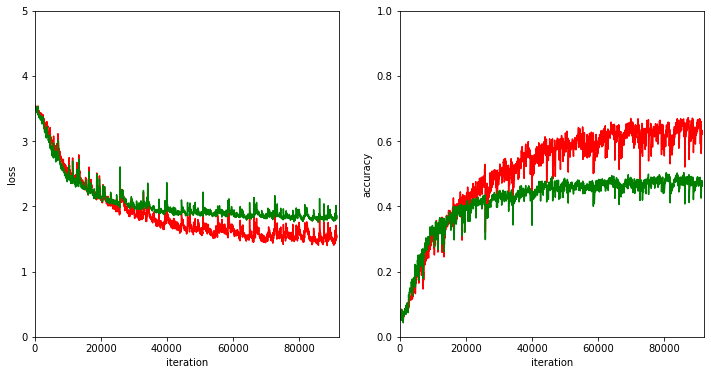

In [7]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,92000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,92000)
acc_graph.set_ylim(0,1)

plt.show() 

# Model with 6 conv layers, weaker dropout, same wt decay

In [15]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( #nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( #nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.2),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.2),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.2),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model1 = PetCNN6()
loss_function = nn.NLLLoss()


print(model1)


    


PetCNN6(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, pa

In [16]:
learning_rate = 0.001
decay_rate = 0.0003
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 300

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        


Epoch:0
Iteration:50
Time taken for the last 50 iterations: 37.707109451293945
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 41.969033002853394
Epoch:0
Iteration:150
Time taken for the last 50 iterations: 41.70103168487549
Epoch:0
Iteration:200
Time taken for the last 50 iterations: 41.36526370048523
Epoch:0
Iteration:250
Time taken for the last 50 iterations: 41.649664878845215
Epoch:1
Iteration:300
Time taken for the last 50 iterations: 40.63211464881897
Current training loss:3.009068250656128
Current training accuracy:0.1875
Current validation loss:2.9231324195861816
Current validation accuracy:0.2023276686668396
Epoch:1
Iteration:350
Time taken for the last 50 iterations: 41.34998297691345
Current training loss:2.990816116333008
Current training accuracy:0.19189453125
Current validation loss:2.8691201210021973
Current validation accuracy:0.21217547357082367
Epoch:1
Iteration:400
Time taken for the last 50 iterations: 41.65957522392273
Current training loss:2.95682477

Current training loss:2.7164528369903564
Current training accuracy:0.23876953125
Current validation loss:2.701493501663208
Current validation accuracy:0.25156670808792114
Epoch:7
Iteration:1900
Time taken for the last 50 iterations: 40.190014362335205
Current training loss:2.3605892658233643
Current training accuracy:0.3408203125
Current validation loss:2.322711706161499
Current validation accuracy:0.34646373987197876
Epoch:7
Iteration:1950
Time taken for the last 50 iterations: 39.38194942474365
Current training loss:2.206340789794922
Current training accuracy:0.3798828125
Current validation loss:2.2155697345733643
Current validation accuracy:0.36705461144447327
Epoch:7
Iteration:2000
Time taken for the last 50 iterations: 41.72171950340271
Current training loss:2.229562282562256
Current training accuracy:0.38720703125
Current validation loss:2.2076454162597656
Current validation accuracy:0.3751119077205658
Epoch:7
Iteration:2050
Time taken for the last 50 iterations: 45.7303473949432

Epoch:13
Iteration:3500
Time taken for the last 50 iterations: 39.944520473480225
Current training loss:1.725063681602478
Current training accuracy:0.5302734375
Current validation loss:1.9469976425170898
Current validation accuracy:0.42972245812416077
Epoch:13
Iteration:3550
Time taken for the last 50 iterations: 39.9181547164917
Current training loss:1.9219814538955688
Current training accuracy:0.44873046875
Current validation loss:2.26517653465271
Current validation accuracy:0.36794987320899963
Epoch:13
Iteration:3600
Time taken for the last 50 iterations: 40.70115399360657
Current training loss:1.6267452239990234
Current training accuracy:0.5556640625
Current validation loss:1.8783552646636963
Current validation accuracy:0.44225603342056274
Epoch:13
Iteration:3650
Time taken for the last 50 iterations: 39.88233733177185
Current training loss:1.5328527688980103
Current training accuracy:0.57958984375
Current validation loss:1.830923318862915
Current validation accuracy:0.461951643228

Current validation loss:1.6786669492721558
Current validation accuracy:0.49597135186195374
Epoch:19
Iteration:5150
Time taken for the last 50 iterations: 31.5223491191864
Current training loss:1.1182889938354492
Current training accuracy:0.72119140625
Current validation loss:1.7384774684906006
Current validation accuracy:0.494180828332901
Epoch:19
Iteration:5200
Time taken for the last 50 iterations: 31.43821930885315
Current training loss:1.084505319595337
Current training accuracy:0.740234375
Current validation loss:1.71898353099823
Current validation accuracy:0.5031334161758423
Epoch:20
Iteration:5250
Time taken for the last 50 iterations: 31.354156017303467
Current training loss:1.060612678527832
Current training accuracy:0.74560546875
Current validation loss:1.6828453540802002
Current validation accuracy:0.5040286779403687
Epoch:20
Iteration:5300
Time taken for the last 50 iterations: 31.922016859054565
Current training loss:0.9828237891197205
Current training accuracy:0.7578125
C

Current training loss:0.9010240435600281
Current training accuracy:0.7958984375
Current validation loss:1.7392023801803589
Current validation accuracy:0.5102954506874084
Epoch:26
Iteration:6800
Time taken for the last 50 iterations: 42.66359758377075
Current training loss:1.069877028465271
Current training accuracy:0.72802734375
Current validation loss:1.8809341192245483
Current validation accuracy:0.4574753940105438
Epoch:26
Iteration:6850
Time taken for the last 50 iterations: 40.95746850967407
Current training loss:0.9185822606086731
Current training accuracy:0.79931640625
Current validation loss:1.7562017440795898
Current validation accuracy:0.5174574851989746
Epoch:26
Iteration:6900
Time taken for the last 50 iterations: 41.232038259506226
Current training loss:0.7661283016204834
Current training accuracy:0.837890625
Current validation loss:1.6691499948501587
Current validation accuracy:0.5129811763763428
Epoch:26
Iteration:6950
Time taken for the last 50 iterations: 40.6374192237

KeyboardInterrupt: 

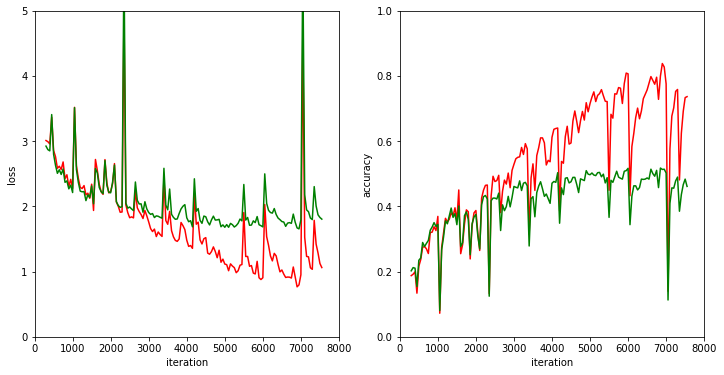

In [17]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,8000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,8000)
acc_graph.set_ylim(0,1)

plt.show() 

The learning is a little too stochastic, and there are signs of overfitting already, and also signs of the training performance plateauing, so we'll decrease the dropout further to facilitate overfitting on the training set, and increase the weight decay slightly.

# Model with 6 conv layers, even weaker dropout, stronger wt decay

In [18]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( #nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( #nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.2),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model1 = PetCNN6()
loss_function = nn.NLLLoss()


print(model1)


    


PetCNN6(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.1, inplace=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, pa

In [19]:
learning_rate = 0.001
decay_rate = 0.0005
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 200

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        


Epoch:0
Iteration:50
Time taken for the last 50 iterations: 35.45454788208008
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 37.25593328475952
Epoch:0
Iteration:150
Time taken for the last 50 iterations: 36.23511099815369
Epoch:0
Iteration:200
Time taken for the last 50 iterations: 36.49747562408447
Epoch:0
Iteration:250
Time taken for the last 50 iterations: 36.67384099960327
Epoch:1
Iteration:300
Time taken for the last 50 iterations: 37.6397762298584
Current training loss:3.3002030849456787
Current training accuracy:0.1240234375
Current validation loss:3.240518569946289
Current validation accuracy:0.12444046884775162
Epoch:1
Iteration:350
Time taken for the last 50 iterations: 36.355738401412964
Current training loss:2.973538398742676
Current training accuracy:0.18310546875
Current validation loss:2.8524410724639893
Current validation accuracy:0.20411817729473114
Epoch:1
Iteration:400
Time taken for the last 50 iterations: 37.56863212585449
Current training loss:2.9655

Current training loss:2.0025782585144043
Current training accuracy:0.439453125
Current validation loss:2.07058048248291
Current validation accuracy:0.41271263360977173
Epoch:7
Iteration:1900
Time taken for the last 50 iterations: 31.440425157546997
Current training loss:2.044630527496338
Current training accuracy:0.41650390625
Current validation loss:2.120820999145508
Current validation accuracy:0.38585495948791504
Epoch:7
Iteration:1950
Time taken for the last 50 iterations: 31.127848863601685
Current training loss:1.903495192527771
Current training accuracy:0.4853515625
Current validation loss:2.0125210285186768
Current validation accuracy:0.4145031273365021
Epoch:7
Iteration:2000
Time taken for the last 50 iterations: 31.308459281921387
Current training loss:1.8878860473632812
Current training accuracy:0.46337890625
Current validation loss:2.0316576957702637
Current validation accuracy:0.43061771988868713
Epoch:7
Iteration:2050
Time taken for the last 50 iterations: 31.3668208122253

Current training loss:1.6342912912368774
Current training accuracy:0.55078125
Current validation loss:1.9842772483825684
Current validation accuracy:0.43330350518226624
Epoch:13
Iteration:3550
Time taken for the last 50 iterations: 30.953760385513306
Current training loss:1.465679407119751
Current training accuracy:0.58935546875
Current validation loss:1.970278263092041
Current validation accuracy:0.42435094714164734
Epoch:13
Iteration:3600
Time taken for the last 50 iterations: 31.014660358428955
Current training loss:1.256466269493103
Current training accuracy:0.67724609375
Current validation loss:1.821695327758789
Current validation accuracy:0.47717100381851196
Epoch:13
Iteration:3650
Time taken for the last 50 iterations: 31.10409140586853
Current training loss:1.2934526205062866
Current training accuracy:0.662109375
Current validation loss:1.8139238357543945
Current validation accuracy:0.4852283000946045
Epoch:14
Iteration:3700
Time taken for the last 50 iterations: 30.45547962188

Epoch:19
Iteration:5150
Time taken for the last 50 iterations: 30.954322338104248
Current training loss:0.845867395401001
Current training accuracy:0.7958984375
Current validation loss:1.7695649862289429
Current validation accuracy:0.506714403629303
Epoch:19
Iteration:5200
Time taken for the last 50 iterations: 31.148645401000977
Current training loss:0.8656706809997559
Current training accuracy:0.80859375
Current validation loss:1.752543568611145
Current validation accuracy:0.48612353205680847
Epoch:20
Iteration:5250
Time taken for the last 50 iterations: 30.912042140960693
Current training loss:0.8731401562690735
Current training accuracy:0.7900390625
Current validation loss:1.7702537775039673
Current validation accuracy:0.5022381544113159
Epoch:20
Iteration:5300
Time taken for the last 50 iterations: 30.999311685562134
Current training loss:0.9314870238304138
Current training accuracy:0.7734375
Current validation loss:1.7637470960617065
Current validation accuracy:0.5076096653938293

Current validation loss:1.8095886707305908
Current validation accuracy:0.48701879382133484
Epoch:26
Iteration:6800
Time taken for the last 50 iterations: 30.44434881210327
Current training loss:0.8851965069770813
Current training accuracy:0.80615234375
Current validation loss:1.8408218622207642
Current validation accuracy:0.4726947247982025
Epoch:26
Iteration:6850
Time taken for the last 50 iterations: 31.02662754058838
Current training loss:0.8416256904602051
Current training accuracy:0.81591796875
Current validation loss:1.8166457414627075
Current validation accuracy:0.48343777656555176
Epoch:26
Iteration:6900
Time taken for the last 50 iterations: 30.960704803466797
Current training loss:0.7352730631828308
Current training accuracy:0.85302734375
Current validation loss:1.75603449344635
Current validation accuracy:0.49507609009742737
Epoch:26
Iteration:6950
Time taken for the last 50 iterations: 31.164985179901123
Current training loss:0.7315661907196045
Current training accuracy:0.8

Current training loss:1.3011040687561035
Current training accuracy:0.619140625
Current validation loss:2.3338780403137207
Current validation accuracy:0.4046553373336792
Epoch:32
Iteration:8450
Time taken for the last 50 iterations: 35.227458477020264
Current training loss:0.9730756878852844
Current training accuracy:0.74560546875
Current validation loss:1.9926095008850098
Current validation accuracy:0.452103853225708
Epoch:32
Iteration:8500
Time taken for the last 50 iterations: 35.53426766395569
Current training loss:0.8455021977424622
Current training accuracy:0.80517578125
Current validation loss:1.90396249294281
Current validation accuracy:0.47448521852493286
Epoch:32
Iteration:8550
Time taken for the last 50 iterations: 35.62961411476135
Current training loss:0.7566325664520264
Current training accuracy:0.84375
Current validation loss:1.858155369758606
Current validation accuracy:0.4726947247982025
Epoch:32
Iteration:8600
Time taken for the last 50 iterations: 35.6431348323822
Cur

Epoch:38
Iteration:10050
Time taken for the last 50 iterations: 35.51308989524841
Current training loss:0.3962303102016449
Current training accuracy:0.9296875
Current validation loss:1.9466118812561035
Current validation accuracy:0.48343777656555176
Epoch:38
Iteration:10100
Time taken for the last 50 iterations: 35.515703201293945
Current training loss:0.4085831642150879
Current training accuracy:0.935546875
Current validation loss:1.972500205039978
Current validation accuracy:0.4762757420539856
Epoch:38
Iteration:10150
Time taken for the last 50 iterations: 35.45951318740845
Current training loss:0.37193843722343445
Current training accuracy:0.935546875
Current validation loss:1.9279050827026367
Current validation accuracy:0.48970457911491394
Epoch:39
Iteration:10200
Time taken for the last 50 iterations: 34.68296933174133
Current training loss:1.7902858257293701
Current training accuracy:0.4833984375
Current validation loss:2.979262113571167
Current validation accuracy:0.339301705360

Current validation loss:1.9351938962936401
Current validation accuracy:0.46284690499305725
Epoch:44
Iteration:11700
Time taken for the last 50 iterations: 35.57570290565491
Current training loss:0.5040240287780762
Current training accuracy:0.904296875
Current validation loss:1.9026031494140625
Current validation accuracy:0.4700089395046234
Epoch:45
Iteration:11750
Time taken for the last 50 iterations: 34.84423565864563
Current training loss:0.662434995174408
Current training accuracy:0.8564453125
Current validation loss:2.161384105682373
Current validation accuracy:0.4189794063568115
Epoch:45
Iteration:11800
Time taken for the last 50 iterations: 35.52981448173523
Current training loss:0.49804726243019104
Current training accuracy:0.91455078125
Current validation loss:1.9027001857757568
Current validation accuracy:0.47806623578071594
Epoch:45
Iteration:11850
Time taken for the last 50 iterations: 35.47240233421326
Current training loss:0.3998682498931885
Current training accuracy:0.93

Current training loss:0.272500604391098
Current training accuracy:0.96435546875
Current validation loss:1.9551891088485718
Current validation accuracy:0.4914950728416443
Epoch:51
Iteration:13350
Time taken for the last 50 iterations: 34.9055860042572
Current training loss:0.8489874005317688
Current training accuracy:0.77099609375
Current validation loss:2.4109888076782227
Current validation accuracy:0.4136078655719757
Epoch:51
Iteration:13400
Time taken for the last 50 iterations: 35.622729539871216
Current training loss:0.5610548853874207
Current training accuracy:0.8857421875
Current validation loss:2.1146042346954346
Current validation accuracy:0.4315129816532135
Epoch:51
Iteration:13450
Time taken for the last 50 iterations: 35.63289213180542
Current training loss:0.5253522992134094
Current training accuracy:0.89892578125
Current validation loss:2.051419258117676
Current validation accuracy:0.4529991149902344
Epoch:51
Iteration:13500
Time taken for the last 50 iterations: 35.691848

Epoch:57
Iteration:14950
Time taken for the last 50 iterations: 35.36334729194641
Current training loss:0.7300652861595154
Current training accuracy:0.81298828125
Current validation loss:2.298866033554077
Current validation accuracy:0.4279319643974304
Epoch:57
Iteration:15000
Time taken for the last 50 iterations: 36.030922174453735
Current training loss:0.5320678353309631
Current training accuracy:0.88134765625
Current validation loss:2.1577236652374268
Current validation accuracy:0.4700089395046234
Epoch:57
Iteration:15050
Time taken for the last 50 iterations: 35.58027172088623
Current training loss:0.4517424404621124
Current training accuracy:0.91259765625
Current validation loss:2.0806221961975098
Current validation accuracy:0.4637421667575836
Epoch:57
Iteration:15100
Time taken for the last 50 iterations: 35.432596921920776
Current training loss:0.3925801217556
Current training accuracy:0.9296875
Current validation loss:2.0522572994232178
Current validation accuracy:0.47806623578

Current validation loss:2.1199169158935547
Current validation accuracy:0.4503133296966553
Epoch:63
Iteration:16600
Time taken for the last 50 iterations: 35.38209080696106
Current training loss:0.3980761766433716
Current training accuracy:0.92578125
Current validation loss:2.119088649749756
Current validation accuracy:0.4583706259727478
Epoch:63
Iteration:16650
Time taken for the last 50 iterations: 35.35396194458008
Current training loss:0.33567437529563904
Current training accuracy:0.9453125
Current validation loss:1.969197392463684
Current validation accuracy:0.4825425148010254
Epoch:63
Iteration:16700
Time taken for the last 50 iterations: 35.48158669471741
Current training loss:0.3097803592681885
Current training accuracy:0.95458984375
Current validation loss:1.991186261177063
Current validation accuracy:0.48075202107429504
Epoch:64
Iteration:16750
Time taken for the last 50 iterations: 34.678990602493286
Current training loss:1.3713515996932983
Current training accuracy:0.59375
C

Current training loss:0.1996326595544815
Current training accuracy:0.9794921875
Current validation loss:2.0270206928253174
Current validation accuracy:0.493285596370697
Epoch:69
Iteration:18250
Time taken for the last 50 iterations: 35.64423370361328
Current training loss:0.17635327577590942
Current training accuracy:0.9775390625
Current validation loss:1.988235354423523
Current validation accuracy:0.49507609009742737
Epoch:70
Iteration:18300
Time taken for the last 50 iterations: 35.02410840988159
Current training loss:0.7488631010055542
Current training accuracy:0.78369140625
Current validation loss:2.5907416343688965
Current validation accuracy:0.3840644657611847
Epoch:70
Iteration:18350
Time taken for the last 50 iterations: 35.69264841079712
Current training loss:0.3853936493396759
Current training accuracy:0.9345703125
Current validation loss:2.2112250328063965
Current validation accuracy:0.4458370506763458
Epoch:70
Iteration:18400
Time taken for the last 50 iterations: 35.490224

Epoch:76
Iteration:19850
Time taken for the last 50 iterations: 34.95673608779907
Current training loss:0.9158141613006592
Current training accuracy:0.75244140625
Current validation loss:2.4806456565856934
Current validation accuracy:0.3831692039966583
Epoch:76
Iteration:19900
Time taken for the last 50 iterations: 35.84890413284302
Current training loss:0.3354237973690033
Current training accuracy:0.9443359375
Current validation loss:2.052232503890991
Current validation accuracy:0.48970457911491394
Epoch:76
Iteration:19950
Time taken for the last 50 iterations: 35.55496287345886
Current training loss:0.27100878953933716
Current training accuracy:0.9619140625
Current validation loss:2.0457310676574707
Current validation accuracy:0.4914950728416443
Epoch:76
Iteration:20000
Time taken for the last 50 iterations: 35.64195656776428
Current training loss:0.23066560924053192
Current training accuracy:0.9658203125
Current validation loss:2.0741679668426514
Current validation accuracy:0.475380

Current validation loss:2.2763564586639404
Current validation accuracy:0.43867501616477966
Epoch:82
Iteration:21500
Time taken for the last 50 iterations: 35.73723602294922
Current training loss:0.29166337847709656
Current training accuracy:0.95556640625
Current validation loss:2.0740017890930176
Current validation accuracy:0.4816472828388214
Epoch:82
Iteration:21550
Time taken for the last 50 iterations: 35.86420488357544
Current training loss:0.24881784617900848
Current training accuracy:0.96240234375
Current validation loss:2.0541961193084717
Current validation accuracy:0.4789614975452423
Epoch:82
Iteration:21600
Time taken for the last 50 iterations: 35.639708042144775
Current training loss:0.2113187164068222
Current training accuracy:0.974609375
Current validation loss:2.0465176105499268
Current validation accuracy:0.48970457911491394
Epoch:82
Iteration:21650
Time taken for the last 50 iterations: 35.694199323654175
Current training loss:0.19443687796592712
Current training accura

KeyboardInterrupt: 

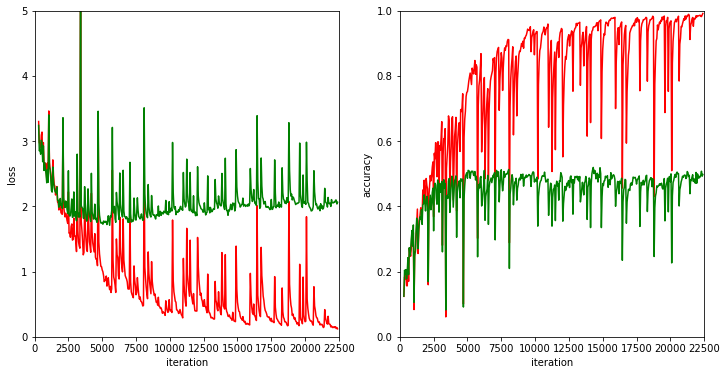

In [21]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,22500)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,22500)
acc_graph.set_ylim(0,1)

plt.show() 

Maybe we need to reduce the learning rate to obtain a smoother learning curve. We'll put in a learning rate decay every few epochs. We'll lower the weight decay back to how it was.

# Model with 6 conv layers, same as above, learning rate decay

In [17]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( #nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( #nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.2),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model1 = PetCNN6()
loss_function = nn.NLLLoss()


print(model1)


    


PetCNN6(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.1, inplace=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, pa

In [18]:
learning_rate = 0.001
decay_rate = 0.0003
lr_decay = 0.75    # we'll go for a learning rate decay by a factor of 0.75 every 3 epochs

optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=lr_decay)

num_epochs = 250

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            print('Current learning rate:{}'.format(optimizer.param_groups[0]['lr']))    # to print the current learning rate that is decaying every 5 epochs
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
            
    scheduler.step()
                

            
        


Epoch:0
Iteration:50
Time taken for the last 50 iterations: 31.30210590362549
Current learning rate:0.001
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 31.247275590896606
Current learning rate:0.001
Epoch:0
Iteration:150
Time taken for the last 50 iterations: 31.163283109664917
Current learning rate:0.001
Epoch:0
Iteration:200
Time taken for the last 50 iterations: 31.33888030052185
Current learning rate:0.001
Epoch:0
Iteration:250
Time taken for the last 50 iterations: 31.204954147338867
Current learning rate:0.001
Epoch:1
Iteration:300
Time taken for the last 50 iterations: 30.586637020111084
Current learning rate:0.001
Current training loss:2.9715144634246826
Current training accuracy:0.18212890625
Current validation loss:2.8480353355407715
Current validation accuracy:0.18710832297801971
Epoch:1
Iteration:350
Time taken for the last 50 iterations: 31.12917160987854
Current learning rate:0.001
Current training loss:3.21372652053833
Current training accuracy:0.129394531

Current validation loss:1.8785475492477417
Current validation accuracy:0.4431512951850891
Epoch:6
Iteration:1700
Time taken for the last 50 iterations: 32.406617641448975
Current learning rate:0.0005625000000000001
Current training loss:1.7842323780059814
Current training accuracy:0.509765625
Current validation loss:1.9738194942474365
Current validation accuracy:0.4279319643974304
Epoch:6
Iteration:1750
Time taken for the last 50 iterations: 30.87161087989807
Current learning rate:0.0005625000000000001
Current training loss:1.8658534288406372
Current training accuracy:0.48779296875
Current validation loss:2.036655902862549
Current validation accuracy:0.4162936508655548
Epoch:6
Iteration:1800
Time taken for the last 50 iterations: 30.923355102539062
Current learning rate:0.0005625000000000001
Current training loss:1.6774344444274902
Current training accuracy:0.53759765625
Current validation loss:1.8593734502792358
Current validation accuracy:0.45120859146118164
Epoch:7
Iteration:1850
Ti

Current training loss:1.30605149269104
Current training accuracy:0.6611328125
Current validation loss:1.8225170373916626
Current validation accuracy:0.47538048028945923
Epoch:11
Iteration:3100
Time taken for the last 50 iterations: 36.09475064277649
Current learning rate:0.00042187500000000005
Current training loss:1.3246212005615234
Current training accuracy:0.66845703125
Current validation loss:1.740607500076294
Current validation accuracy:0.4995523691177368
Epoch:12
Iteration:3150
Time taken for the last 50 iterations: 35.323203802108765
Current learning rate:0.00031640625000000006
Current training loss:1.3264857530593872
Current training accuracy:0.646484375
Current validation loss:1.8098702430725098
Current validation accuracy:0.48075202107429504
Epoch:12
Iteration:3200
Time taken for the last 50 iterations: 35.9855010509491
Current learning rate:0.00031640625000000006
Current training loss:1.2678333520889282
Current training accuracy:0.69482421875
Current validation loss:1.758413

Current training loss:1.0773069858551025
Current training accuracy:0.7333984375
Current validation loss:1.8292546272277832
Current validation accuracy:0.47806623578071594
Epoch:17
Iteration:4500
Time taken for the last 50 iterations: 38.475329875946045
Current learning rate:0.00023730468750000005
Current training loss:0.8921719789505005
Current training accuracy:0.80859375
Current validation loss:1.7177071571350098
Current validation accuracy:0.5049238801002502
Epoch:17
Iteration:4550
Time taken for the last 50 iterations: 37.983280658721924
Current learning rate:0.00023730468750000005
Current training loss:0.8737331032752991
Current training accuracy:0.80908203125
Current validation loss:1.7202959060668945
Current validation accuracy:0.4995523691177368
Epoch:17
Iteration:4600
Time taken for the last 50 iterations: 38.10566234588623
Current learning rate:0.00023730468750000005
Current training loss:0.8200770616531372
Current training accuracy:0.822265625
Current validation loss:1.71203

Current training loss:0.5962693095207214
Current training accuracy:0.90234375
Current validation loss:1.7136822938919067
Current validation accuracy:0.5147716999053955
Epoch:22
Iteration:5900
Time taken for the last 50 iterations: 40.18616271018982
Current learning rate:0.00013348388671875002
Current training loss:0.5861884951591492
Current training accuracy:0.89990234375
Current validation loss:1.7113633155822754
Current validation accuracy:0.5049238801002502
Epoch:22
Iteration:5950
Time taken for the last 50 iterations: 39.92365217208862
Current learning rate:0.00013348388671875002
Current training loss:0.5538184642791748
Current training accuracy:0.91259765625
Current validation loss:1.7069191932678223
Current validation accuracy:0.49865710735321045
Epoch:22
Iteration:6000
Time taken for the last 50 iterations: 39.88940215110779
Current learning rate:0.00013348388671875002
Current training loss:0.5941026210784912
Current training accuracy:0.89501953125
Current validation loss:1.7038

Current training loss:0.44261011481285095
Current training accuracy:0.931640625
Current validation loss:1.7124227285385132
Current validation accuracy:0.494180828332901
Epoch:27
Iteration:7300
Time taken for the last 50 iterations: 39.98340439796448
Current learning rate:7.508468627929689e-05
Current training loss:0.4701579213142395
Current training accuracy:0.9267578125
Current validation loss:1.7027925252914429
Current validation accuracy:0.5040286779403687
Epoch:28
Iteration:7350
Time taken for the last 50 iterations: 38.80618619918823
Current learning rate:7.508468627929689e-05
Current training loss:0.4837167263031006
Current training accuracy:0.92724609375
Current validation loss:1.7240334749221802
Current validation accuracy:0.5040286779403687
Epoch:28
Iteration:7400
Time taken for the last 50 iterations: 40.15431237220764
Current learning rate:7.508468627929689e-05
Current training loss:0.44894006848335266
Current training accuracy:0.9326171875
Current validation loss:1.70770597

KeyboardInterrupt: 

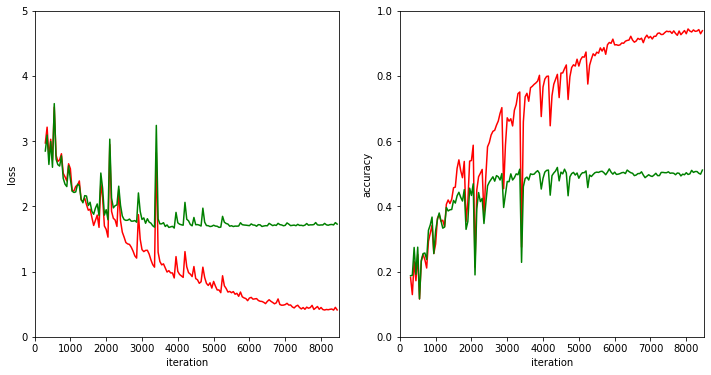

In [19]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,8500)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,8500)
acc_graph.set_ylim(0,1)

plt.show() 

We'll reduce the decay of the learning rate a little bit.

# Model with 6 conv layers, same as above, learning rate decay slower

In [20]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( #nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( #nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.2),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model1 = PetCNN6()
loss_function = nn.NLLLoss()


print(model1)


    


PetCNN6(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.1, inplace=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, pa

In [21]:
learning_rate = 0.001
decay_rate = 0.0003
lr_decay = 0.9    # we'll go for a learning rate decay by a factor of 0.9 every 3 epochs

optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=lr_decay)

num_epochs = 250

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            print('Current learning rate:{}'.format(optimizer.param_groups[0]['lr']))    # to print the current learning rate that is decaying every 5 epochs
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
            
    scheduler.step()
                

            
        


Epoch:0
Iteration:50
Time taken for the last 50 iterations: 37.22094392776489
Current learning rate:0.001
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 41.03692293167114
Current learning rate:0.001
Epoch:0
Iteration:150
Time taken for the last 50 iterations: 41.63857054710388
Current learning rate:0.001
Epoch:0
Iteration:200
Time taken for the last 50 iterations: 41.41459918022156
Current learning rate:0.001
Epoch:0
Iteration:250
Time taken for the last 50 iterations: 41.747716665267944
Current learning rate:0.001
Epoch:1
Iteration:300
Time taken for the last 50 iterations: 38.7311851978302
Current learning rate:0.001
Current training loss:2.9988362789154053
Current training accuracy:0.17431640625
Current validation loss:2.847085475921631
Current validation accuracy:0.20680393278598785
Epoch:1
Iteration:350
Time taken for the last 50 iterations: 41.68260097503662
Current learning rate:0.001
Current training loss:3.0017266273498535
Current training accuracy:0.1630859375
C

Current validation loss:1.9904619455337524
Current validation accuracy:0.4136078655719757
Epoch:6
Iteration:1650
Time taken for the last 50 iterations: 58.42815041542053
Current learning rate:0.0008100000000000001
Current training loss:1.8843486309051514
Current training accuracy:0.46240234375
Current validation loss:2.077437162399292
Current validation accuracy:0.3921217620372772
Epoch:6
Iteration:1700
Time taken for the last 50 iterations: 58.770238161087036
Current learning rate:0.0008100000000000001
Current training loss:1.6330455541610718
Current training accuracy:0.53125
Current validation loss:1.9004627466201782
Current validation accuracy:0.452103853225708
Epoch:6
Iteration:1750
Time taken for the last 50 iterations: 55.88308072090149
Current learning rate:0.0008100000000000001
Current training loss:1.693433165550232
Current training accuracy:0.53271484375
Current validation loss:1.9023629426956177
Current validation accuracy:0.43061771988868713
Epoch:6
Iteration:1800
Time take

Current training loss:1.083339810371399
Current training accuracy:0.73486328125
Current validation loss:1.7569515705108643
Current validation accuracy:0.4995523691177368
Epoch:11
Iteration:3100
Time taken for the last 50 iterations: 58.36610221862793
Current learning rate:0.000729
Current training loss:1.0570496320724487
Current training accuracy:0.72900390625
Current validation loss:1.7788180112838745
Current validation accuracy:0.4905998110771179
Epoch:12
Iteration:3150
Time taken for the last 50 iterations: 55.847846269607544
Current learning rate:0.0006561000000000001
Current training loss:1.1111223697662354
Current training accuracy:0.7314453125
Current validation loss:1.7777339220046997
Current validation accuracy:0.4852283000946045
Epoch:12
Iteration:3200
Time taken for the last 50 iterations: 57.84372687339783
Current learning rate:0.0006561000000000001
Current training loss:1.0179357528686523
Current training accuracy:0.77392578125
Current validation loss:1.7431013584136963
Cu

Current validation loss:1.7607053518295288
Current validation accuracy:0.4825425148010254
Epoch:17
Iteration:4500
Time taken for the last 50 iterations: 58.20432734489441
Current learning rate:0.00059049
Current training loss:0.6783920526504517
Current training accuracy:0.86328125
Current validation loss:1.7594795227050781
Current validation accuracy:0.49865710735321045
Epoch:17
Iteration:4550
Time taken for the last 50 iterations: 58.57049489021301
Current learning rate:0.00059049
Current training loss:0.6019672751426697
Current training accuracy:0.8818359375
Current validation loss:1.7860641479492188
Current validation accuracy:0.49239033460617065
Epoch:17
Iteration:4600
Time taken for the last 50 iterations: 58.71824765205383
Current learning rate:0.00059049
Current training loss:0.5636670589447021
Current training accuracy:0.890625
Current validation loss:1.7684540748596191
Current validation accuracy:0.5165622234344482
Epoch:17
Iteration:4650
Time taken for the last 50 iterations:

Current training loss:0.3386630117893219
Current training accuracy:0.9453125
Current validation loss:1.8097586631774902
Current validation accuracy:0.5085049271583557
Epoch:22
Iteration:5950
Time taken for the last 50 iterations: 57.448832273483276
Current learning rate:0.0004782969
Current training loss:0.31345051527023315
Current training accuracy:0.96142578125
Current validation loss:1.833825707435608
Current validation accuracy:0.5058191418647766
Epoch:22
Iteration:6000
Time taken for the last 50 iterations: 55.418198585510254
Current learning rate:0.0004782969
Current training loss:0.3166810870170593
Current training accuracy:0.95458984375
Current validation loss:1.8221514225006104
Current validation accuracy:0.5085049271583557
Epoch:23
Iteration:6050
Time taken for the last 50 iterations: 54.85467720031738
Current learning rate:0.0004782969
Current training loss:0.6407617330551147
Current training accuracy:0.8427734375
Current validation loss:2.0493903160095215
Current validation

Epoch:28
Iteration:7350
Time taken for the last 50 iterations: 53.44286060333252
Current learning rate:0.000387420489
Current training loss:0.2988421618938446
Current training accuracy:0.9609375
Current validation loss:1.8641382455825806
Current validation accuracy:0.49776187539100647
Epoch:28
Iteration:7400
Time taken for the last 50 iterations: 57.70175051689148
Current learning rate:0.000387420489
Current training loss:0.30466708540916443
Current training accuracy:0.95849609375
Current validation loss:1.8866380453109741
Current validation accuracy:0.5085049271583557
Epoch:28
Iteration:7450
Time taken for the last 50 iterations: 56.35794425010681
Current learning rate:0.000387420489
Current training loss:0.3192654252052307
Current training accuracy:0.94775390625
Current validation loss:1.8646548986434937
Current validation accuracy:0.5076096653938293
Epoch:28
Iteration:7500
Time taken for the last 50 iterations: 56.80989742279053
Current learning rate:0.000387420489
Current training 

Current training loss:0.3240568935871124
Current training accuracy:0.95263671875
Current validation loss:1.928529977798462
Current validation accuracy:0.48970457911491394
Epoch:33
Iteration:8800
Time taken for the last 50 iterations: 56.06271457672119
Current learning rate:0.00031381059609000004
Current training loss:0.2861776053905487
Current training accuracy:0.9609375
Current validation loss:1.9141157865524292
Current validation accuracy:0.49776187539100647
Epoch:33
Iteration:8850
Time taken for the last 50 iterations: 57.06858849525452
Current learning rate:0.00031381059609000004
Current training loss:0.25387144088745117
Current training accuracy:0.96875
Current validation loss:1.8936259746551514
Current validation accuracy:0.494180828332901
Epoch:34
Iteration:8900
Time taken for the last 50 iterations: 56.46236515045166
Current learning rate:0.00031381059609000004
Current training loss:0.2761903405189514
Current training accuracy:0.95849609375
Current validation loss:1.99924707412

Current training loss:0.1720048487186432
Current training accuracy:0.98193359375
Current validation loss:1.977494478225708
Current validation accuracy:0.4995523691177368
Epoch:39
Iteration:10200
Time taken for the last 50 iterations: 53.99211835861206
Current learning rate:0.00025418658283290005
Current training loss:0.16628962755203247
Current training accuracy:0.97998046875
Current validation loss:1.9828710556030273
Current validation accuracy:0.5022381544113159
Epoch:39
Iteration:10250
Time taken for the last 50 iterations: 57.133322954177856
Current learning rate:0.00025418658283290005
Current training loss:0.1642245501279831
Current training accuracy:0.982421875
Current validation loss:1.9682321548461914
Current validation accuracy:0.49776187539100647
Epoch:39
Iteration:10300
Time taken for the last 50 iterations: 58.402421951293945
Current learning rate:0.00025418658283290005
Current training loss:0.13359381258487701
Current training accuracy:0.9921875
Current validation loss:1.9

Epoch:44
Iteration:11550
Time taken for the last 50 iterations: 57.80240488052368
Current learning rate:0.00022876792454961005
Current training loss:0.10524038225412369
Current training accuracy:0.98974609375
Current validation loss:1.9754670858383179
Current validation accuracy:0.5013428926467896
Epoch:44
Iteration:11600
Time taken for the last 50 iterations: 58.336745262145996
Current learning rate:0.00022876792454961005
Current training loss:0.09729315340518951
Current training accuracy:0.99169921875
Current validation loss:1.984908103942871
Current validation accuracy:0.5013428926467896
Epoch:44
Iteration:11650
Time taken for the last 50 iterations: 58.02164697647095
Current learning rate:0.00022876792454961005
Current training loss:0.11561094224452972
Current training accuracy:0.98681640625
Current validation loss:2.0068743228912354
Current validation accuracy:0.5031334161758423
Epoch:44
Iteration:11700
Time taken for the last 50 iterations: 57.688785791397095
Current learning rat

Current validation loss:2.0769131183624268
Current validation accuracy:0.493285596370697
Epoch:49
Iteration:12950
Time taken for the last 50 iterations: 54.950058937072754
Current learning rate:0.00018530201888518417
Current training loss:0.10273457318544388
Current training accuracy:0.98828125
Current validation loss:2.0692138671875
Current validation accuracy:0.5040286779403687
Epoch:49
Iteration:13000
Time taken for the last 50 iterations: 57.652064085006714
Current learning rate:0.00018530201888518417
Current training loss:0.09621822834014893
Current training accuracy:0.99072265625
Current validation loss:2.0874147415161133
Current validation accuracy:0.4995523691177368
Epoch:49
Iteration:13050
Time taken for the last 50 iterations: 51.16299057006836
Current learning rate:0.00018530201888518417
Current training loss:0.0977049171924591
Current training accuracy:0.9892578125
Current validation loss:2.0978870391845703
Current validation accuracy:0.4879140555858612
Epoch:50
Iteration:1

KeyboardInterrupt: 

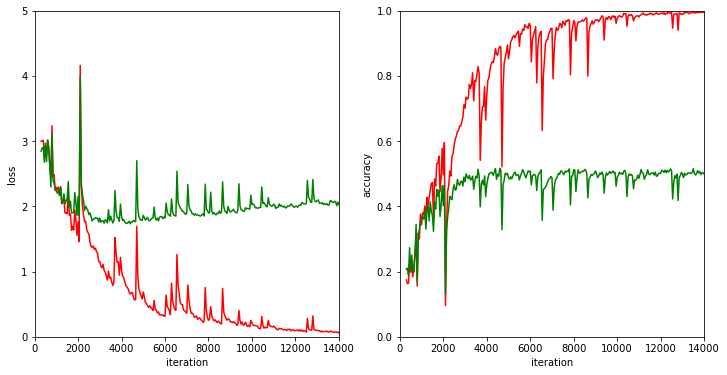

In [22]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,14000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,14000)
acc_graph.set_ylim(0,1)

plt.show() 

# Same as above stronger lr decay

Now we only want to train till the point that the validation accuracy is the max and the validation loss is at the minimum, this is around 51% with a loss of around 1.73-1.76. We'll use stronger lr decay to reach this point more smoothly.

In [6]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( #nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( #nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.2),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model1 = PetCNN6()
loss_function = nn.NLLLoss()



learning_rate = 0.001
decay_rate = 0.0003
lr_decay = 0.75    # we'll go for a learning rate decay by a factor of 0.75 every 2 epochs

optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=lr_decay)

num_epochs = 120

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            print('Current learning rate:{}'.format(optimizer.param_groups[0]['lr']))    # to print the current learning rate that is decaying every 5 epochs
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
            
    scheduler.step()
                

            
        

    


Epoch:0
Iteration:50
Time taken for the last 50 iterations: 62.559508323669434
Current learning rate:0.001
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 65.38589835166931
Current learning rate:0.001
Epoch:0
Iteration:150
Time taken for the last 50 iterations: 64.88330388069153
Current learning rate:0.001
Epoch:0
Iteration:200
Time taken for the last 50 iterations: 64.58746814727783
Current learning rate:0.001
Epoch:0
Iteration:250
Time taken for the last 50 iterations: 58.060863971710205
Current learning rate:0.001
Epoch:1
Iteration:300
Time taken for the last 50 iterations: 51.48219180107117
Current learning rate:0.001
Current training loss:3.0126285552978516
Current training accuracy:0.17138671875
Current validation loss:2.877777576446533
Current validation accuracy:0.21575649082660675
Epoch:1
Iteration:350
Time taken for the last 50 iterations: 53.4684476852417
Current learning rate:0.001
Current training loss:2.876199722290039
Current training accuracy:0.203125
Curre

Epoch:6
Iteration:1650
Time taken for the last 50 iterations: 61.35467839241028
Current learning rate:0.00042187500000000005
Current training loss:1.700446605682373
Current training accuracy:0.53515625
Current validation loss:1.8590147495269775
Current validation accuracy:0.45658013224601746
Epoch:6
Iteration:1700
Time taken for the last 50 iterations: 57.07668948173523
Current learning rate:0.00042187500000000005
Current training loss:1.7320598363876343
Current training accuracy:0.5048828125
Current validation loss:1.8802423477172852
Current validation accuracy:0.45658013224601746
Epoch:6
Iteration:1750
Time taken for the last 50 iterations: 56.626707553863525
Current learning rate:0.00042187500000000005
Current training loss:1.613391637802124
Current training accuracy:0.55419921875
Current validation loss:1.8079850673675537
Current validation accuracy:0.48612353205680847
Epoch:6
Iteration:1800
Time taken for the last 50 iterations: 64.39473080635071
Current learning rate:0.0004218750

Current validation loss:1.6569902896881104
Current validation accuracy:0.5219337344169617
Epoch:11
Iteration:3050
Time taken for the last 50 iterations: 63.22706174850464
Current learning rate:0.00023730468750000005
Current training loss:0.9537823796272278
Current training accuracy:0.78076171875
Current validation loss:1.664703369140625
Current validation accuracy:0.5102954506874084
Epoch:11
Iteration:3100
Time taken for the last 50 iterations: 59.859787940979004
Current learning rate:0.00023730468750000005
Current training loss:0.9416747093200684
Current training accuracy:0.7890625
Current validation loss:1.6416521072387695
Current validation accuracy:0.534467339515686
Epoch:12
Iteration:3150
Time taken for the last 50 iterations: 52.92076325416565
Current learning rate:0.00017797851562500002
Current training loss:1.051695704460144
Current training accuracy:0.75341796875
Current validation loss:1.7458239793777466
Current validation accuracy:0.5022381544113159
Epoch:12
Iteration:3200
T

Current training loss:0.6257675886154175
Current training accuracy:0.89892578125
Current validation loss:1.6300908327102661
Current validation accuracy:0.5273053050041199
Epoch:17
Iteration:4450
Time taken for the last 50 iterations: 58.86143684387207
Current learning rate:0.00010011291503906251
Current training loss:0.7277517914772034
Current training accuracy:0.8447265625
Current validation loss:1.7373440265655518
Current validation accuracy:0.5004476308822632
Epoch:17
Iteration:4500
Time taken for the last 50 iterations: 69.08597302436829
Current learning rate:0.00010011291503906251
Current training loss:0.6302313208580017
Current training accuracy:0.89306640625
Current validation loss:1.664320707321167
Current validation accuracy:0.5264100432395935
Epoch:17
Iteration:4550
Time taken for the last 50 iterations: 61.70028328895569
Current learning rate:0.00010011291503906251
Current training loss:0.6512480974197388
Current training accuracy:0.88671875
Current validation loss:1.6527004

Current training loss:0.5430869460105896
Current training accuracy:0.9111328125
Current validation loss:1.6322413682937622
Current validation accuracy:0.534467339515686
Epoch:22
Iteration:5850
Time taken for the last 50 iterations: 60.87820649147034
Current learning rate:4.22351360321045e-05
Current training loss:0.516673743724823
Current training accuracy:0.9228515625
Current validation loss:1.629881739616394
Current validation accuracy:0.5326768159866333
Epoch:22
Iteration:5900
Time taken for the last 50 iterations: 58.022045373916626
Current learning rate:4.22351360321045e-05
Current training loss:0.4899146556854248
Current training accuracy:0.92724609375
Current validation loss:1.6180493831634521
Current validation accuracy:0.534467339515686
Epoch:22
Iteration:5950
Time taken for the last 50 iterations: 59.7325279712677
Current learning rate:4.22351360321045e-05
Current training loss:0.46018123626708984
Current training accuracy:0.9287109375
Current validation loss:1.62470257282257

Current training loss:0.42094549536705017
Current training accuracy:0.939453125
Current validation loss:1.6347907781600952
Current validation accuracy:0.5273053050041199


KeyboardInterrupt: 

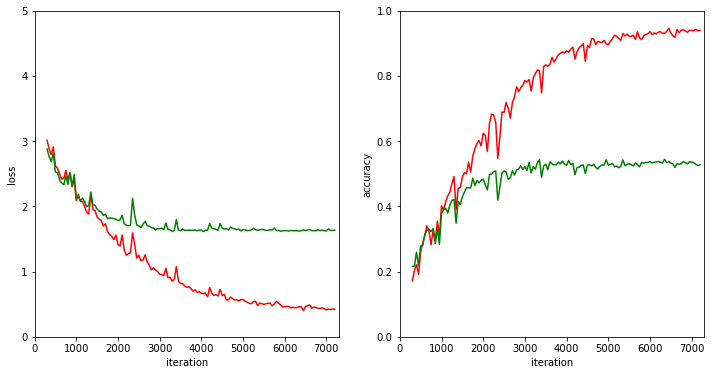

In [7]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,7300)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,7300)
acc_graph.set_ylim(0,1)

plt.show() 

# Model with 7 conv layers, very weak dropout, rel strong wt decay

In [7]:
class PetCNN7(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( #nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( #nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(32),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( #nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( #nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),            
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( #nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),            
                                    nn.BatchNorm2d(512),
                                    nn.ReLU())
        
        self.conv7 = nn.Sequential( #nn.Dropout(0.2),
                                    nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3),            
                                    nn.BatchNorm2d(1024),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(#nn.Dropout(0.2),
                                    nn.Linear(1024, 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.conv7(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model1 = PetCNN7()
loss_function = nn.NLLLoss()


print(model1)
        

PetCNN7(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
   

In [8]:
learning_rate = 0.001
decay_rate = 0.0002
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 300

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        

Epoch:0
Iteration:50
Time taken for the last 50 iterations: 13.44819164276123
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 13.781204462051392
Epoch:0
Iteration:150
Time taken for the last 50 iterations: 14.03149938583374
Epoch:0
Iteration:200
Time taken for the last 50 iterations: 15.753845691680908
Epoch:0
Iteration:250
Time taken for the last 50 iterations: 15.520121335983276
Epoch:1
Iteration:300
Time taken for the last 50 iterations: 16.154430866241455
Current training loss:3.584179162979126
Current training accuracy:0.06640625
Current validation loss:3.4133477210998535
Current validation accuracy:0.09937331825494766
Epoch:1
Iteration:350
Time taken for the last 50 iterations: 16.398268222808838
Current training loss:3.2668933868408203
Current training accuracy:0.10888671875
Current validation loss:3.1989097595214844
Current validation accuracy:0.1253357231616974
Epoch:1
Iteration:400
Time taken for the last 50 iterations: 16.569198608398438
Current training loss:3.

Current training loss:3.1570961475372314
Current training accuracy:0.1552734375
Current validation loss:3.1976897716522217
Current validation accuracy:0.15846015512943268
Epoch:7
Iteration:1900
Time taken for the last 50 iterations: 14.833694458007812
Current training loss:2.9839558601379395
Current training accuracy:0.16162109375
Current validation loss:2.8561172485351562
Current validation accuracy:0.2050134241580963
Epoch:7
Iteration:1950
Time taken for the last 50 iterations: 13.75067138671875
Current training loss:2.791614294052124
Current training accuracy:0.216796875
Current validation loss:2.5948617458343506
Current validation accuracy:0.2560429871082306
Epoch:7
Iteration:2000
Time taken for the last 50 iterations: 14.862576961517334
Current training loss:2.7546751499176025
Current training accuracy:0.21875
Current validation loss:2.717665195465088
Current validation accuracy:0.23455685377120972
Epoch:7
Iteration:2050
Time taken for the last 50 iterations: 15.00462031364441
Cur

Current training loss:2.6574270725250244
Current training accuracy:0.2607421875
Current validation loss:2.9528145790100098
Current validation accuracy:0.20322291553020477
Epoch:13
Iteration:3550
Time taken for the last 50 iterations: 13.852719068527222
Current training loss:2.4490432739257812
Current training accuracy:0.296875
Current validation loss:2.568681001663208
Current validation accuracy:0.28469112515449524
Epoch:13
Iteration:3600
Time taken for the last 50 iterations: 15.136036396026611
Current training loss:3.1401803493499756
Current training accuracy:0.18310546875
Current validation loss:3.3319880962371826
Current validation accuracy:0.17099373042583466
Epoch:13
Iteration:3650
Time taken for the last 50 iterations: 15.604574918746948
Current training loss:2.5690841674804688
Current training accuracy:0.267578125
Current validation loss:2.559623956680298
Current validation accuracy:0.2766338288784027
Epoch:14
Iteration:3700
Time taken for the last 50 iterations: 14.94424510002

Epoch:19
Iteration:5150
Time taken for the last 50 iterations: 14.458224058151245
Current training loss:1.930225133895874
Current training accuracy:0.42724609375
Current validation loss:2.45095157623291
Current validation accuracy:0.32587286829948425
Epoch:19
Iteration:5200
Time taken for the last 50 iterations: 14.199934959411621
Current training loss:2.1401329040527344
Current training accuracy:0.38818359375
Current validation loss:2.5544981956481934
Current validation accuracy:0.29632946848869324
Epoch:20
Iteration:5250
Time taken for the last 50 iterations: 14.018650770187378
Current training loss:2.7168381214141846
Current training accuracy:0.28662109375
Current validation loss:3.223491907119751
Current validation accuracy:0.22470904886722565
Epoch:20
Iteration:5300
Time taken for the last 50 iterations: 14.510930061340332
Current training loss:1.9256924390792847
Current training accuracy:0.43603515625
Current validation loss:2.4644038677215576
Current validation accuracy:0.320501

Current validation loss:2.6204843521118164
Current validation accuracy:0.315129816532135
Epoch:26
Iteration:6800
Time taken for the last 50 iterations: 15.89151406288147
Current training loss:2.1670985221862793
Current training accuracy:0.37060546875
Current validation loss:3.0366268157958984
Current validation accuracy:0.2506714463233948
Epoch:26
Iteration:6850
Time taken for the last 50 iterations: 15.337873458862305
Current training loss:1.7418657541275024
Current training accuracy:0.49365234375
Current validation loss:2.55578351020813
Current validation accuracy:0.3160250782966614
Epoch:26
Iteration:6900
Time taken for the last 50 iterations: 15.778642177581787
Current training loss:1.663435459136963
Current training accuracy:0.5087890625
Current validation loss:2.696333408355713
Current validation accuracy:0.31154879927635193
Epoch:26
Iteration:6950
Time taken for the last 50 iterations: 15.677327394485474
Current training loss:1.8052738904953003
Current training accuracy:0.461914

Current training loss:2.2628653049468994
Current training accuracy:0.359375
Current validation loss:3.2152302265167236
Current validation accuracy:0.24171888828277588
Epoch:32
Iteration:8450
Time taken for the last 50 iterations: 18.835313320159912
Current training loss:1.4755103588104248
Current training accuracy:0.56005859375
Current validation loss:2.639197826385498
Current validation accuracy:0.3240823745727539
Epoch:32
Iteration:8500
Time taken for the last 50 iterations: 18.8460054397583
Current training loss:1.7579737901687622
Current training accuracy:0.490234375
Current validation loss:2.971461772918701
Current validation accuracy:0.28469112515449524
Epoch:32
Iteration:8550
Time taken for the last 50 iterations: 18.648273229599
Current training loss:1.6249585151672363
Current training accuracy:0.5087890625
Current validation loss:2.9558653831481934
Current validation accuracy:0.29006266593933105
Epoch:32
Iteration:8600
Time taken for the last 50 iterations: 19.751021146774292


Epoch:38
Iteration:10050
Time taken for the last 50 iterations: 32.60267615318298
Current training loss:0.8069278597831726
Current training accuracy:0.7802734375
Current validation loss:2.885300874710083
Current validation accuracy:0.34646373987197876
Epoch:38
Iteration:10100
Time taken for the last 50 iterations: 33.03210163116455
Current training loss:0.7268418669700623
Current training accuracy:0.7978515625
Current validation loss:2.7962088584899902
Current validation accuracy:0.3482542634010315
Epoch:38
Iteration:10150
Time taken for the last 50 iterations: 32.83615446090698
Current training loss:1.0497188568115234
Current training accuracy:0.6923828125
Current validation loss:3.2181265354156494
Current validation accuracy:0.3240823745727539
Epoch:39
Iteration:10200
Time taken for the last 50 iterations: 32.49294877052307
Current training loss:0.9705175161361694
Current training accuracy:0.70751953125
Current validation loss:3.1350924968719482
Current validation accuracy:0.29095792

KeyboardInterrupt: 

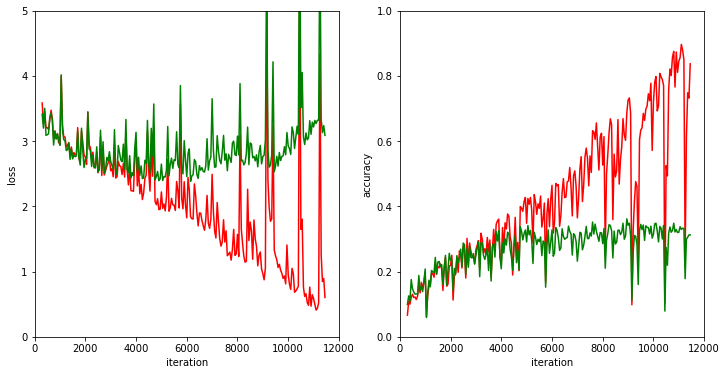

In [9]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,12000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,12000)
acc_graph.set_ylim(0,1)

plt.show() 

# Model with 8 conv layers

We'll reduce the learning rate coz the learning curve is not too smooth.

In [10]:
class PetCNN8(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( #nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( #nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(32),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( #nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3), 
                                    nn.MaxPool2d(kernel_size=3,stride=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=2),            
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv7 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=2),            
                                    nn.BatchNorm2d(512),
                                    nn.ReLU())
        
        self.conv8 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=2),            
                                    nn.BatchNorm2d(1024),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.2),
                                    nn.Linear(1024, 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.conv7(out)
        out = self.conv8(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model1 = PetCNN8()
loss_function = nn.NLLLoss()


print(model1)
        

PetCNN8(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    

In [11]:
learning_rate = 0.0005
decay_rate = 0.0001
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 300

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        


Epoch:0
Iteration:50
Time taken for the last 50 iterations: 11.356432914733887
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 14.416577339172363
Epoch:0
Iteration:150
Time taken for the last 50 iterations: 15.407092571258545
Epoch:0
Iteration:200
Time taken for the last 50 iterations: 15.307556867599487
Epoch:0
Iteration:250
Time taken for the last 50 iterations: 15.859415054321289
Epoch:1
Iteration:300
Time taken for the last 50 iterations: 15.376062393188477
Current training loss:3.267137050628662
Current training accuracy:0.1162109375
Current validation loss:3.198310375213623
Current validation accuracy:0.12085944414138794
Epoch:1
Iteration:350
Time taken for the last 50 iterations: 15.785575151443481
Current training loss:3.2387940883636475
Current training accuracy:0.09912109375
Current validation loss:3.17684268951416
Current validation accuracy:0.12264995276927948
Epoch:1
Iteration:400
Time taken for the last 50 iterations: 15.291536808013916
Current training loss:

Current training loss:3.016404390335083
Current training accuracy:0.17431640625
Current validation loss:2.991501569747925
Current validation accuracy:0.16114592552185059
Epoch:7
Iteration:1900
Time taken for the last 50 iterations: 13.507096767425537
Current training loss:2.8472368717193604
Current training accuracy:0.201171875
Current validation loss:2.8478927612304688
Current validation accuracy:0.20143240690231323
Epoch:7
Iteration:1950
Time taken for the last 50 iterations: 13.24771785736084
Current training loss:2.799569845199585
Current training accuracy:0.22412109375
Current validation loss:2.847517490386963
Current validation accuracy:0.20590868592262268
Epoch:7
Iteration:2000
Time taken for the last 50 iterations: 13.259243488311768
Current training loss:2.8326613903045654
Current training accuracy:0.212890625
Current validation loss:2.8516745567321777
Current validation accuracy:0.20322291553020477
Epoch:7
Iteration:2050
Time taken for the last 50 iterations: 13.1735534667968

Epoch:13
Iteration:3500
Time taken for the last 50 iterations: 13.152018785476685
Current training loss:2.52412486076355
Current training accuracy:0.27001953125
Current validation loss:2.7034966945648193
Current validation accuracy:0.2381378710269928
Epoch:13
Iteration:3550
Time taken for the last 50 iterations: 13.122495412826538
Current training loss:2.410539388656616
Current training accuracy:0.3173828125
Current validation loss:2.606259822845459
Current validation accuracy:0.2551477253437042
Epoch:13
Iteration:3600
Time taken for the last 50 iterations: 13.164563417434692
Current training loss:2.535095453262329
Current training accuracy:0.2705078125
Current validation loss:2.7210988998413086
Current validation accuracy:0.22560429573059082
Epoch:13
Iteration:3650
Time taken for the last 50 iterations: 13.15643048286438
Current training loss:2.43648362159729
Current training accuracy:0.31640625
Current validation loss:2.667393207550049
Current validation accuracy:0.23992837965488434


Current validation loss:2.9226791858673096
Current validation accuracy:0.2264995574951172
Epoch:19
Iteration:5150
Time taken for the last 50 iterations: 13.270473718643188
Current training loss:2.2489352226257324
Current training accuracy:0.35009765625
Current validation loss:2.5921027660369873
Current validation accuracy:0.26947179436683655
Epoch:19
Iteration:5200
Time taken for the last 50 iterations: 13.180653810501099
Current training loss:2.2864787578582764
Current training accuracy:0.33935546875
Current validation loss:2.5811166763305664
Current validation accuracy:0.2820053696632385
Epoch:20
Iteration:5250
Time taken for the last 50 iterations: 12.983724117279053
Current training loss:2.2279765605926514
Current training accuracy:0.3544921875
Current validation loss:2.6045985221862793
Current validation accuracy:0.27305281162261963
Epoch:20
Iteration:5300
Time taken for the last 50 iterations: 13.024096727371216
Current training loss:2.1351675987243652
Current training accuracy:0

Current training loss:2.059715986251831
Current training accuracy:0.3955078125
Current validation loss:2.6670007705688477
Current validation accuracy:0.2685765326023102
Epoch:26
Iteration:6800
Time taken for the last 50 iterations: 12.78421664237976
Current training loss:2.3582656383514404
Current training accuracy:0.337890625
Current validation loss:2.8558218479156494
Current validation accuracy:0.24261415004730225
Epoch:26
Iteration:6850
Time taken for the last 50 iterations: 13.688910722732544
Current training loss:1.9935111999511719
Current training accuracy:0.41552734375
Current validation loss:2.536945104598999
Current validation accuracy:0.28379589319229126
Epoch:26
Iteration:6900
Time taken for the last 50 iterations: 12.905962705612183
Current training loss:2.0993871688842773
Current training accuracy:0.37548828125
Current validation loss:2.734854221343994
Current validation accuracy:0.2676813006401062
Epoch:26
Iteration:6950
Time taken for the last 50 iterations: 13.442297935

Epoch:32
Iteration:8400
Time taken for the last 50 iterations: 11.270310163497925
Current training loss:1.8060303926467896
Current training accuracy:0.46337890625
Current validation loss:2.662259578704834
Current validation accuracy:0.2802148759365082
Epoch:32
Iteration:8450
Time taken for the last 50 iterations: 11.354695796966553
Current training loss:1.7164689302444458
Current training accuracy:0.48974609375
Current validation loss:2.572669506072998
Current validation accuracy:0.2882721722126007
Epoch:32
Iteration:8500
Time taken for the last 50 iterations: 11.180744409561157
Current training loss:1.6794291734695435
Current training accuracy:0.50439453125
Current validation loss:2.5433104038238525
Current validation accuracy:0.3061772584915161
Epoch:32
Iteration:8550
Time taken for the last 50 iterations: 11.334311723709106
Current training loss:1.8902219533920288
Current training accuracy:0.45166015625
Current validation loss:2.7601613998413086
Current validation accuracy:0.2802148

Current validation loss:2.6372716426849365
Current validation accuracy:0.30259624123573303
Epoch:38
Iteration:10050
Time taken for the last 50 iterations: 11.18082571029663
Current training loss:1.4561558961868286
Current training accuracy:0.578125
Current validation loss:2.624413251876831
Current validation accuracy:0.3097582757472992
Epoch:38
Iteration:10100
Time taken for the last 50 iterations: 11.328081369400024
Current training loss:1.4687623977661133
Current training accuracy:0.560546875
Current validation loss:2.602738380432129
Current validation accuracy:0.3124440610408783
Epoch:38
Iteration:10150
Time taken for the last 50 iterations: 12.348706007003784
Current training loss:1.4239451885223389
Current training accuracy:0.58740234375
Current validation loss:2.661189556121826
Current validation accuracy:0.3070725202560425
Epoch:39
Iteration:10200
Time taken for the last 50 iterations: 11.333117723464966
Current training loss:2.9534084796905518
Current training accuracy:0.240234

Current training loss:1.1957463026046753
Current training accuracy:0.64306640625
Current validation loss:2.6607162952423096
Current validation accuracy:0.31065353751182556
Epoch:44
Iteration:11700
Time taken for the last 50 iterations: 10.859277486801147
Current training loss:1.2395479679107666
Current training accuracy:0.63134765625
Current validation loss:2.7060060501098633
Current validation accuracy:0.3187108337879181
Epoch:45
Iteration:11750
Time taken for the last 50 iterations: 10.500677585601807
Current training loss:4.818460941314697
Current training accuracy:0.12646484375
Current validation loss:5.629385948181152
Current validation accuracy:0.09489704668521881
Epoch:45
Iteration:11800
Time taken for the last 50 iterations: 10.757996320724487
Current training loss:1.6309549808502197
Current training accuracy:0.51708984375
Current validation loss:2.924487590789795
Current validation accuracy:0.2587287425994873
Epoch:45
Iteration:11850
Time taken for the last 50 iterations: 10.8

Epoch:50
Iteration:13300
Time taken for the last 50 iterations: 10.747581958770752
Current training loss:1.1411205530166626
Current training accuracy:0.68359375
Current validation loss:2.6893393993377686
Current validation accuracy:0.3124440610408783
Epoch:51
Iteration:13350
Time taken for the last 50 iterations: 11.492890119552612
Current training loss:1.1848801374435425
Current training accuracy:0.6591796875
Current validation loss:2.692115306854248
Current validation accuracy:0.3097582757472992
Epoch:51
Iteration:13400
Time taken for the last 50 iterations: 11.483563423156738
Current training loss:1.1663926839828491
Current training accuracy:0.66796875
Current validation loss:2.773664951324463
Current validation accuracy:0.30259624123573303
Epoch:51
Iteration:13450
Time taken for the last 50 iterations: 12.297725915908813
Current training loss:1.1068834066390991
Current training accuracy:0.67333984375
Current validation loss:2.711486339569092
Current validation accuracy:0.3160250782

Current validation loss:3.7702572345733643
Current validation accuracy:0.23455685377120972
Epoch:57
Iteration:14950
Time taken for the last 50 iterations: 12.477415323257446
Current training loss:1.2249119281768799
Current training accuracy:0.63671875
Current validation loss:2.949498176574707
Current validation accuracy:0.2891674041748047
Epoch:57
Iteration:15000
Time taken for the last 50 iterations: 13.527374505996704
Current training loss:0.9715467095375061
Current training accuracy:0.73388671875
Current validation loss:2.8343803882598877
Current validation accuracy:0.3034915030002594
Epoch:57
Iteration:15050
Time taken for the last 50 iterations: 13.399788856506348
Current training loss:0.9594685435295105
Current training accuracy:0.73779296875
Current validation loss:2.8834125995635986
Current validation accuracy:0.3034915030002594
Epoch:57
Iteration:15100
Time taken for the last 50 iterations: 12.506787776947021
Current training loss:0.879568338394165
Current training accuracy:0.

KeyboardInterrupt: 

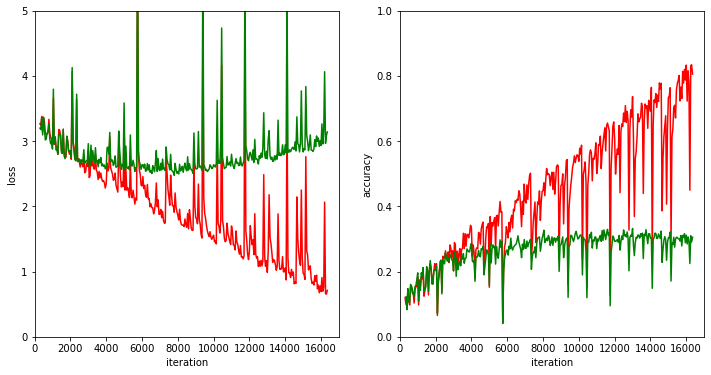

In [12]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,17000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,17000)
acc_graph.set_ylim(0,1)

plt.show() 

# Model with 5 conv layers

In [9]:
class PetCNN5(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=4,stride=2),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(32),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=2, stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.2),
                                    nn.Linear(370, 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    

loss_function = nn.NLLLoss()


model1 = PetCNN5()
print(model1)



PetCNN5(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.1, inplace=False)
    (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.1, inplace=False)
    (1): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2))
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.1, inplace=False)
    (1): Conv2d(128

In [10]:
learning_rate = 0.001
decay_rate = 0.0002
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 150

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        


Epoch:0
Iteration:50
Time taken for the last 50 iterations: 11.340670824050903
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 11.466614007949829
Epoch:0
Iteration:150
Time taken for the last 50 iterations: 11.611213684082031
Epoch:0
Iteration:200
Time taken for the last 50 iterations: 12.155840396881104
Epoch:0
Iteration:250
Time taken for the last 50 iterations: 18.246365547180176
Epoch:1
Iteration:300
Time taken for the last 50 iterations: 19.838939666748047
Current training loss:3.1818480491638184
Current training accuracy:0.1318359375
Current validation loss:3.0888659954071045
Current validation accuracy:0.13339301943778992
Epoch:1
Iteration:350
Time taken for the last 50 iterations: 19.04153800010681
Current training loss:3.1992220878601074
Current training accuracy:0.12646484375
Current validation loss:3.1238858699798584
Current validation accuracy:0.13518352806568146
Epoch:1
Iteration:400
Time taken for the last 50 iterations: 21.413408041000366
Current training lo

Current training loss:2.7548062801361084
Current training accuracy:0.236328125
Current validation loss:2.6896896362304688
Current validation accuracy:0.2444046586751938
Epoch:7
Iteration:1900
Time taken for the last 50 iterations: 19.49669599533081
Current training loss:2.6798343658447266
Current training accuracy:0.2509765625
Current validation loss:2.6494338512420654
Current validation accuracy:0.2497761845588684
Epoch:7
Iteration:1950
Time taken for the last 50 iterations: 18.774667739868164
Current training loss:2.6372294425964355
Current training accuracy:0.27099609375
Current validation loss:2.593043327331543
Current validation accuracy:0.27573859691619873
Epoch:7
Iteration:2000
Time taken for the last 50 iterations: 18.99955129623413
Current training loss:2.5990142822265625
Current training accuracy:0.24755859375
Current validation loss:2.581943988800049
Current validation accuracy:0.24529990553855896
Epoch:7
Iteration:2050
Time taken for the last 50 iterations: 18.9748170375823

Current training loss:2.384103536605835
Current training accuracy:0.3193359375
Current validation loss:2.494138479232788
Current validation accuracy:0.2855863869190216
Epoch:13
Iteration:3550
Time taken for the last 50 iterations: 19.893361568450928
Current training loss:2.381366491317749
Current training accuracy:0.32080078125
Current validation loss:2.52252197265625
Current validation accuracy:0.2855863869190216
Epoch:13
Iteration:3600
Time taken for the last 50 iterations: 19.55203127861023
Current training loss:2.2371153831481934
Current training accuracy:0.38818359375
Current validation loss:2.4002110958099365
Current validation accuracy:0.30796778202056885
Epoch:13
Iteration:3650
Time taken for the last 50 iterations: 20.19245195388794
Current training loss:2.2528679370880127
Current training accuracy:0.36767578125
Current validation loss:2.428637742996216
Current validation accuracy:0.29006266593933105
Epoch:14
Iteration:3700
Time taken for the last 50 iterations: 19.15819048881

Epoch:19
Iteration:5150
Time taken for the last 50 iterations: 19.248343467712402
Current training loss:2.016920804977417
Current training accuracy:0.42822265625
Current validation loss:2.3096587657928467
Current validation accuracy:0.3267681300640106
Epoch:19
Iteration:5200
Time taken for the last 50 iterations: 19.05741548538208
Current training loss:2.0029361248016357
Current training accuracy:0.43701171875
Current validation loss:2.304210901260376
Current validation accuracy:0.3357206881046295
Epoch:20
Iteration:5250
Time taken for the last 50 iterations: 19.89549160003662
Current training loss:2.8012325763702393
Current training accuracy:0.22216796875
Current validation loss:2.940828800201416
Current validation accuracy:0.1960608810186386
Epoch:20
Iteration:5300
Time taken for the last 50 iterations: 18.720329761505127
Current training loss:2.549927234649658
Current training accuracy:0.29345703125
Current validation loss:2.6499826908111572
Current validation accuracy:0.24709041416

Current validation loss:2.299577236175537
Current validation accuracy:0.33840644359588623
Epoch:26
Iteration:6800
Time taken for the last 50 iterations: 20.74688220024109
Current training loss:2.1300339698791504
Current training accuracy:0.390625
Current validation loss:2.5551068782806396
Current validation accuracy:0.27215757966041565
Epoch:26
Iteration:6850
Time taken for the last 50 iterations: 21.121071815490723
Current training loss:1.8838903903961182
Current training accuracy:0.48583984375
Current validation loss:2.353785276412964
Current validation accuracy:0.3061772584915161
Epoch:26
Iteration:6900
Time taken for the last 50 iterations: 21.487295389175415
Current training loss:1.871564507484436
Current training accuracy:0.46728515625
Current validation loss:2.327202796936035
Current validation accuracy:0.3366159498691559
Epoch:26
Iteration:6950
Time taken for the last 50 iterations: 20.273586750030518
Current training loss:1.873079538345337
Current training accuracy:0.482910156

Current training loss:1.9857025146484375
Current training accuracy:0.42431640625
Current validation loss:2.5464651584625244
Current validation accuracy:0.273948073387146
Epoch:32
Iteration:8450
Time taken for the last 50 iterations: 16.42291021347046
Current training loss:1.8057844638824463
Current training accuracy:0.5009765625
Current validation loss:2.3397693634033203
Current validation accuracy:0.3339301645755768
Epoch:32
Iteration:8500
Time taken for the last 50 iterations: 16.194434881210327
Current training loss:1.6932927370071411
Current training accuracy:0.53076171875
Current validation loss:2.363448143005371
Current validation accuracy:0.3070725202560425
Epoch:32
Iteration:8550
Time taken for the last 50 iterations: 16.443307638168335
Current training loss:1.6586116552352905
Current training accuracy:0.55615234375
Current validation loss:2.3108320236206055
Current validation accuracy:0.31960609555244446
Epoch:32
Iteration:8600
Time taken for the last 50 iterations: 16.2552587

Epoch:38
Iteration:10050
Time taken for the last 50 iterations: 16.985737085342407
Current training loss:1.5061321258544922
Current training accuracy:0.60888671875
Current validation loss:2.349457263946533
Current validation accuracy:0.32945388555526733
Epoch:38
Iteration:10100
Time taken for the last 50 iterations: 16.70874285697937
Current training loss:1.486602544784546
Current training accuracy:0.6044921875
Current validation loss:2.349823474884033
Current validation accuracy:0.3419874608516693
Epoch:38
Iteration:10150
Time taken for the last 50 iterations: 16.55617094039917
Current training loss:1.4080753326416016
Current training accuracy:0.63427734375
Current validation loss:2.3441765308380127
Current validation accuracy:0.33213967084884644
Epoch:39
Iteration:10200
Time taken for the last 50 iterations: 17.210378408432007
Current training loss:1.4073024988174438
Current training accuracy:0.62939453125
Current validation loss:2.338146448135376
Current validation accuracy:0.327663

Current validation loss:2.4315426349639893
Current validation accuracy:0.3178155720233917
Epoch:44
Iteration:11700
Time taken for the last 50 iterations: 16.412603855133057
Current training loss:1.2137154340744019
Current training accuracy:0.6923828125
Current validation loss:2.411278247833252
Current validation accuracy:0.3339301645755768
Epoch:45
Iteration:11750
Time taken for the last 50 iterations: 16.30128502845764
Current training loss:1.2480570077896118
Current training accuracy:0.6767578125
Current validation loss:2.4111862182617188
Current validation accuracy:0.34109219908714294
Epoch:45
Iteration:11800
Time taken for the last 50 iterations: 16.62128710746765
Current training loss:1.2263484001159668
Current training accuracy:0.69091796875
Current validation loss:2.4143922328948975
Current validation accuracy:0.32855865359306335
Epoch:45
Iteration:11850
Time taken for the last 50 iterations: 17.09921932220459
Current training loss:1.202797532081604
Current training accuracy:0.6

Current training loss:0.8677290678024292
Current training accuracy:0.80517578125
Current validation loss:2.4360570907592773
Current validation accuracy:0.3366159498691559
Epoch:51
Iteration:13350
Time taken for the last 50 iterations: 16.314735412597656
Current training loss:0.8536137342453003
Current training accuracy:0.80908203125
Current validation loss:2.4616634845733643
Current validation accuracy:0.3482542634010315
Epoch:51
Iteration:13400
Time taken for the last 50 iterations: 17.338409900665283
Current training loss:0.8593796491622925
Current training accuracy:0.79833984375
Current validation loss:2.512979507446289
Current validation accuracy:0.3187108337879181
Epoch:51
Iteration:13450
Time taken for the last 50 iterations: 16.91136360168457
Current training loss:0.8692354559898376
Current training accuracy:0.7880859375
Current validation loss:2.523002862930298
Current validation accuracy:0.34019696712493896
Epoch:51
Iteration:13500
Time taken for the last 50 iterations: 16.543

Epoch:57
Iteration:14950
Time taken for the last 50 iterations: 17.214770078659058
Current training loss:1.0088127851486206
Current training accuracy:0.759765625
Current validation loss:2.5074384212493896
Current validation accuracy:0.32229185104370117
Epoch:57
Iteration:15000
Time taken for the last 50 iterations: 16.998841047286987
Current training loss:0.9702296257019043
Current training accuracy:0.7822265625
Current validation loss:2.4935343265533447
Current validation accuracy:0.3097582757472992
Epoch:57
Iteration:15050
Time taken for the last 50 iterations: 17.394556522369385
Current training loss:0.9341906905174255
Current training accuracy:0.7861328125
Current validation loss:2.4871909618377686
Current validation accuracy:0.33482542634010315
Epoch:57
Iteration:15100
Time taken for the last 50 iterations: 16.9912166595459
Current training loss:0.9387038946151733
Current training accuracy:0.79638671875
Current validation loss:2.4875354766845703
Current validation accuracy:0.32676

Current validation loss:2.514634132385254
Current validation accuracy:0.3178155720233917
Epoch:63
Iteration:16600
Time taken for the last 50 iterations: 17.897292375564575
Current training loss:0.885516881942749
Current training accuracy:0.802734375
Current validation loss:2.512855291366577
Current validation accuracy:0.33124440908432007
Epoch:63
Iteration:16650
Time taken for the last 50 iterations: 17.818809747695923
Current training loss:0.86025470495224
Current training accuracy:0.81298828125
Current validation loss:2.514244318008423
Current validation accuracy:0.3303491473197937
Epoch:63
Iteration:16700
Time taken for the last 50 iterations: 17.004079580307007
Current training loss:0.8122225403785706
Current training accuracy:0.83154296875
Current validation loss:2.50956130027771
Current validation accuracy:0.32587286829948425
Epoch:64
Iteration:16750
Time taken for the last 50 iterations: 16.763740062713623
Current training loss:1.2297163009643555
Current training accuracy:0.6826

Current training loss:0.9249563813209534
Current training accuracy:0.78662109375
Current validation loss:2.5259437561035156
Current validation accuracy:0.30796778202056885
Epoch:69
Iteration:18250
Time taken for the last 50 iterations: 17.764148235321045
Current training loss:0.91595458984375
Current training accuracy:0.798828125
Current validation loss:2.5233054161071777
Current validation accuracy:0.31960609555244446
Epoch:70
Iteration:18300
Time taken for the last 50 iterations: 16.738431453704834
Current training loss:0.9229908585548401
Current training accuracy:0.787109375
Current validation loss:2.521484613418579
Current validation accuracy:0.3178155720233917
Epoch:70
Iteration:18350
Time taken for the last 50 iterations: 18.11861228942871
Current training loss:0.8817008137702942
Current training accuracy:0.79541015625
Current validation loss:2.5018820762634277
Current validation accuracy:0.3339301645755768
Epoch:70
Iteration:18400
Time taken for the last 50 iterations: 18.446900

Epoch:76
Iteration:19850
Time taken for the last 50 iterations: 17.52301788330078
Current training loss:0.7541258335113525
Current training accuracy:0.83056640625
Current validation loss:2.584575653076172
Current validation accuracy:0.3187108337879181
Epoch:76
Iteration:19900
Time taken for the last 50 iterations: 17.555673360824585
Current training loss:0.7417578101158142
Current training accuracy:0.84375
Current validation loss:2.5618391036987305
Current validation accuracy:0.3205013573169708
Epoch:76
Iteration:19950
Time taken for the last 50 iterations: 16.84346318244934
Current training loss:0.7174520492553711
Current training accuracy:0.84765625
Current validation loss:2.561354637145996
Current validation accuracy:0.34109219908714294
Epoch:76
Iteration:20000
Time taken for the last 50 iterations: 17.030856370925903
Current training loss:0.6329598426818848
Current training accuracy:0.8798828125
Current validation loss:2.5441651344299316
Current validation accuracy:0.33751118183135

Current validation loss:2.8591930866241455
Current validation accuracy:0.28469112515449524
Epoch:82
Iteration:21500
Time taken for the last 50 iterations: 17.818581342697144
Current training loss:0.9680468440055847
Current training accuracy:0.759765625
Current validation loss:2.708134889602661
Current validation accuracy:0.2891674041748047
Epoch:82
Iteration:21550
Time taken for the last 50 iterations: 17.238805055618286
Current training loss:0.9201292991638184
Current training accuracy:0.79833984375
Current validation loss:2.655440092086792
Current validation accuracy:0.3061772584915161
Epoch:82
Iteration:21600
Time taken for the last 50 iterations: 17.219146013259888
Current training loss:0.8319542407989502
Current training accuracy:0.830078125
Current validation loss:2.629689931869507
Current validation accuracy:0.30259624123573303
Epoch:82
Iteration:21650
Time taken for the last 50 iterations: 17.3489031791687
Current training loss:0.7890074849128723
Current training accuracy:0.839

Current training loss:0.6422852873802185
Current training accuracy:0.876953125
Current validation loss:2.5876269340515137
Current validation accuracy:0.31423455476760864
Epoch:88
Iteration:23150
Time taken for the last 50 iterations: 17.786848306655884
Current training loss:0.6082009673118591
Current training accuracy:0.88037109375
Current validation loss:2.6513092517852783
Current validation accuracy:0.3205013573169708
Epoch:88
Iteration:23200
Time taken for the last 50 iterations: 18.568435192108154
Current training loss:0.6136394739151001
Current training accuracy:0.884765625
Current validation loss:2.6266443729400635
Current validation accuracy:0.31154879927635193
Epoch:89
Iteration:23250
Time taken for the last 50 iterations: 17.724140644073486
Current training loss:0.6077231764793396
Current training accuracy:0.884765625
Current validation loss:2.6596994400024414
Current validation accuracy:0.3160250782966614
Epoch:89
Iteration:23300
Time taken for the last 50 iterations: 18.6800

Epoch:94
Iteration:24750
Time taken for the last 50 iterations: 17.688441514968872
Current training loss:0.5214956998825073
Current training accuracy:0.90625
Current validation loss:2.6588010787963867
Current validation accuracy:0.3213965892791748
Epoch:95
Iteration:24800
Time taken for the last 50 iterations: 17.788012266159058
Current training loss:0.6893542408943176
Current training accuracy:0.8349609375
Current validation loss:2.9009387493133545
Current validation accuracy:0.27215757966041565
Epoch:95
Iteration:24850
Time taken for the last 50 iterations: 17.864572048187256
Current training loss:0.6090294122695923
Current training accuracy:0.87158203125
Current validation loss:2.693549156188965
Current validation accuracy:0.3097582757472992
Epoch:95
Iteration:24900
Time taken for the last 50 iterations: 17.6443350315094
Current training loss:0.5584084987640381
Current training accuracy:0.8896484375
Current validation loss:2.727354049682617
Current validation accuracy:0.317815572023

Current validation loss:2.7877092361450195
Current validation accuracy:0.3133392930030823
Epoch:101
Iteration:26400
Time taken for the last 50 iterations: 18.22001028060913
Current training loss:1.062626600265503
Current training accuracy:0.70947265625
Current validation loss:3.120535373687744
Current validation accuracy:0.261414498090744
Epoch:101
Iteration:26450
Time taken for the last 50 iterations: 17.93578577041626
Current training loss:0.8115497827529907
Current training accuracy:0.80712890625
Current validation loss:2.8688690662384033
Current validation accuracy:0.28379589319229126
Epoch:101
Iteration:26500
Time taken for the last 50 iterations: 17.07254910469055
Current training loss:0.750056266784668
Current training accuracy:0.8427734375
Current validation loss:2.781464099884033
Current validation accuracy:0.2909579277038574
Epoch:101
Iteration:26550
Time taken for the last 50 iterations: 17.601661205291748
Current training loss:0.6553454399108887
Current training accuracy:0.

Epoch:107
Iteration:28000
Time taken for the last 50 iterations: 18.73806619644165
Current training loss:0.65000981092453
Current training accuracy:0.8681640625
Current validation loss:2.7861247062683105
Current validation accuracy:0.29364368319511414
Epoch:107
Iteration:28050
Time taken for the last 50 iterations: 18.96124529838562
Current training loss:0.5988656878471375
Current training accuracy:0.884765625
Current validation loss:2.7227940559387207
Current validation accuracy:0.30438676476478577
Epoch:107
Iteration:28100
Time taken for the last 50 iterations: 18.029907941818237
Current training loss:0.5695050954818726
Current training accuracy:0.892578125
Current validation loss:2.7344417572021484
Current validation accuracy:0.31065353751182556
Epoch:107
Iteration:28150
Time taken for the last 50 iterations: 18.34625744819641
Current training loss:0.49204567074775696
Current training accuracy:0.91943359375
Current validation loss:2.7160487174987793
Current validation accuracy:0.317

Current training loss:0.39084139466285706
Current training accuracy:0.94287109375
Current validation loss:2.817826747894287
Current validation accuracy:0.30170097947120667
Epoch:113
Iteration:29650
Time taken for the last 50 iterations: 18.838563919067383
Current training loss:0.3730866611003876
Current training accuracy:0.94189453125
Current validation loss:2.803311347961426
Current validation accuracy:0.3178155720233917
Epoch:113
Iteration:29700
Time taken for the last 50 iterations: 17.933806657791138
Current training loss:0.3627597391605377
Current training accuracy:0.94677734375
Current validation loss:2.8112502098083496
Current validation accuracy:0.31154879927635193
Epoch:113
Iteration:29750
Time taken for the last 50 iterations: 18.770167350769043
Current training loss:0.35990095138549805
Current training accuracy:0.94384765625
Current validation loss:2.813746690750122
Current validation accuracy:0.31065353751182556
Epoch:114
Iteration:29800
Time taken for the last 50 iteration

Current validation loss:2.758924722671509
Current validation accuracy:0.32229185104370117
Epoch:119
Iteration:31250
Time taken for the last 50 iterations: 18.4355890750885
Current training loss:0.3140236437320709
Current training accuracy:0.94970703125
Current validation loss:2.7623937129974365
Current validation accuracy:0.3366159498691559
Epoch:119
Iteration:31300
Time taken for the last 50 iterations: 18.394119262695312
Current training loss:0.3163241744041443
Current training accuracy:0.9541015625
Current validation loss:2.743955135345459
Current validation accuracy:0.3267681300640106
Epoch:120
Iteration:31350
Time taken for the last 50 iterations: 17.631115436553955
Current training loss:0.3587583899497986
Current training accuracy:0.93994140625
Current validation loss:2.7694449424743652
Current validation accuracy:0.3240823745727539
Epoch:120
Iteration:31400
Time taken for the last 50 iterations: 17.704893350601196
Current training loss:0.31849533319473267
Current training accura

Epoch:125
Iteration:32850
Time taken for the last 50 iterations: 18.772397994995117
Current training loss:0.280503511428833
Current training accuracy:0.9599609375
Current validation loss:2.7992286682128906
Current validation accuracy:0.31960609555244446
Epoch:126
Iteration:32900
Time taken for the last 50 iterations: 17.19658875465393
Current training loss:0.6832841038703918
Current training accuracy:0.82763671875
Current validation loss:3.128638982772827
Current validation accuracy:0.27215757966041565
Epoch:126
Iteration:32950
Time taken for the last 50 iterations: 17.30988883972168
Current training loss:0.4994850754737854
Current training accuracy:0.8984375
Current validation loss:2.8707852363586426
Current validation accuracy:0.3088630139827728
Epoch:126
Iteration:33000
Time taken for the last 50 iterations: 17.57035756111145
Current training loss:0.4606477916240692
Current training accuracy:0.90380859375
Current validation loss:2.8596973419189453
Current validation accuracy:0.29901

Current training loss:0.28011953830718994
Current training accuracy:0.9580078125
Current validation loss:2.8224804401397705
Current validation accuracy:0.32587286829948425
Epoch:132
Iteration:34500
Time taken for the last 50 iterations: 16.477707862854004
Current training loss:0.5255739688873291
Current training accuracy:0.8935546875
Current validation loss:2.9604978561401367
Current validation accuracy:0.3070725202560425
Epoch:132
Iteration:34550
Time taken for the last 50 iterations: 17.324568271636963
Current training loss:0.44236820936203003
Current training accuracy:0.9248046875
Current validation loss:2.797241449356079
Current validation accuracy:0.3124440610408783
Epoch:132
Iteration:34600
Time taken for the last 50 iterations: 17.551878213882446
Current training loss:0.3800722360610962
Current training accuracy:0.93603515625
Current validation loss:2.815575361251831
Current validation accuracy:0.30796778202056885
Epoch:132
Iteration:34650
Time taken for the last 50 iterations: 

Epoch:138
Iteration:36100
Time taken for the last 50 iterations: 16.932010173797607
Current training loss:0.2851232886314392
Current training accuracy:0.96435546875
Current validation loss:2.821232795715332
Current validation accuracy:0.32229185104370117
Epoch:138
Iteration:36150
Time taken for the last 50 iterations: 17.058640718460083
Current training loss:0.2651289999485016
Current training accuracy:0.9736328125
Current validation loss:2.813972234725952
Current validation accuracy:0.32229185104370117
Epoch:138
Iteration:36200
Time taken for the last 50 iterations: 17.488626956939697
Current training loss:0.2804914116859436
Current training accuracy:0.9580078125
Current validation loss:2.810046434402466
Current validation accuracy:0.31960609555244446
Epoch:138
Iteration:36250
Time taken for the last 50 iterations: 17.901238441467285
Current training loss:0.26978132128715515
Current training accuracy:0.9599609375
Current validation loss:2.8130784034729004
Current validation accuracy:0

Current training loss:0.5771061182022095
Current training accuracy:0.8740234375
Current validation loss:2.838658094406128
Current validation accuracy:0.30438676476478577
Epoch:144
Iteration:37750
Time taken for the last 50 iterations: 18.166813135147095
Current training loss:0.5022246241569519
Current training accuracy:0.9091796875
Current validation loss:2.832920551300049
Current validation accuracy:0.31065353751182556
Epoch:144
Iteration:37800
Time taken for the last 50 iterations: 17.531872034072876
Current training loss:0.4518033564090729
Current training accuracy:0.93115234375
Current validation loss:2.8024823665618896
Current validation accuracy:0.31065353751182556
Epoch:145
Iteration:37850
Time taken for the last 50 iterations: 17.176770210266113
Current training loss:0.4470900297164917
Current training accuracy:0.9296875
Current validation loss:2.8355419635772705
Current validation accuracy:0.2909579277038574
Epoch:145
Iteration:37900
Time taken for the last 50 iterations: 18.3

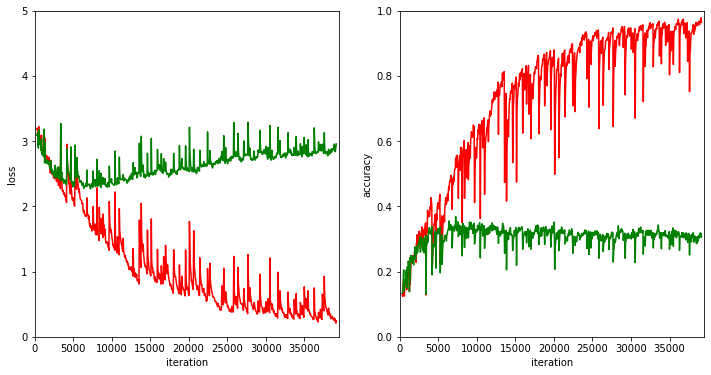

In [12]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,39500)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,39500)
acc_graph.set_ylim(0,1)

plt.show() 